# <center> Predictive Modeling for Purchase Intent in Website Browsing Sessions

## Required installations

In [1]:
%pip install missingno    #installing missingno it helps in vizualizing missing data patterns in dataset
%pip install openpyxl     #openpyxl it hlelps in reading aand writing the excel files in python

## Imports

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.express as px
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, mean_squared_error, roc_curve,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import plot_tree
from scipy import stats, interp
from openpyxl.utils.cell import get_column_letter # importing all the reqquired libraries that are used for every step of project such as vizualization, model preparation, classifiers etc

## Utility Functions

In [73]:
#This function is used to replace required values in the given columns of a DataFrame
def replace_values(data: pd.DataFrame, columns, value_to_replace, replaced_value):

    for col in columns:
        data[col] = data[col].replace({value_to_replace: replaced_value})
    return

#This function is used to find zeros in a column and replace NaN values in other column with zeros
def find_zeros_and_replace(data, col_1, col_2):

    nans = data[col_1].isna()
    for i in range(len(nans)):
        if nans[i]:
            if data[col_2][i] == 0:
                data[col_1][i] = 0

    nans_1 = data[col_2].isna()
    for i in range(len(nans_1)):
        if nans_1[i]:
            if data[col_1][i] == 0:
                data[col_2][i] = 0
    return

#This Function adds percentage labels to bar plots for better understanding
def barPerc(df, xVar, ax):

    # here we are finding how many X categories
    numX = len([x for x in df[xVar].unique() if x == x])

    #here we are organizing The bars are created in hue order
    bars = ax.patches
    for ind in range(numX):

        hueBars = bars[ind:][::numX]

        total = sum([x.get_height() for x in hueBars])

        #here we are Printing the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), f'{bar.get_height()/total:.0%}', ha="center", va="bottom")
    return

# This function is used to remove outliers
def remove_outlires(data, labels, outlier_dict):
    '''
    Removes columns that have outlier values.
    These tresholds are defined in the dictionary we defined.
    In addition, this function deletes the relevant lines from the label column.
    '''
    labels_mask = np.ones((data.shape[0], ), dtype = int)

    for item in outlier_dict.items():
        mask_item = data[item[0]] > item[1]
        data = data.loc[(data[item[0]] <= item[1])]
        labels_mask = labels_mask - mask_item
    if labels is None:
        return data
    labels_mask = labels_mask.apply(lambda x: True if x==1 else False)
    labels = labels[labels_mask]

    return data, labels

# This function is used to remove outliers from data based on a dictionary of threshold values
def remove_outliers(data, labels, outlier_dict):

    labels_mask = np.ones((data.shape[0],), dtype=int)

    for item in outlier_dict.items():
        mask_item = data[item[0]] > item[1]
        data = data.loc[(data[item[0]] <= item[1])]
        labels_mask = labels_mask - mask_item

    if labels is None:
        return data
    labels_mask = labels_mask.apply(lambda x: True if x == 1 else False)
    labels = labels[labels_mask]

    return data, labels

#This function to remove outliers in test data based on a given dictionary of threshold values
def remove_outlires_for_test_processing(data, outlier_dict):

    for item in outlier_dict.items():
        # Selecting the rows where the column values are inside the defined threshold
        data = data.loc[(data[item[0]] <= item[1])]
    return data

# Function to remove outliers in a DataFrame based on the interquartile range (IQR)
def remove_outlier_iqr(df_in, col_name):
    '''
    This function replaces the outliers with np.nan.
    Outliers are defined as values lower than 'min' or greater than 'max'.
    '''
    # Calculating quartiles and interquartile range
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range

    # Defining the lower and upper thresholds for outliers
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr

    # Selecting rows where the column values are within the defined threshold
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# Function to remove records with many NaN values in a DataFrame based on a threshold
def remove_records_with_many_nans(data, threshold):
    # Identify rows with a number of NaN values exceeding the specified threshold
    rows_with_many_nans = data.isna().sum(axis=1) > threshold
    many_nans_row_idx = data[rows_with_many_nans].index
    many_nans_row_idx = many_nans_row_idx.tolist()

    # Dropping rows which are having many NaN values
    data.drop(many_nans_row_idx, axis=0, inplace=True)
    return data

# Function to remove records with many NaN values in both data and labels based on a threshold
def remove_records_with_many_nans_VAL(data, labels, threshold):
    # Identify rows with a number of NaN values exceeding the specified threshold
    rows_with_many_nans = data.isna().sum(axis=1) > threshold
    many_nans_row_idx = data[rows_with_many_nans].index
    many_nans_row_idx = many_nans_row_idx.tolist()

    # Dropping rows with many NaN values in both data and labels
    data.drop(many_nans_row_idx, axis=0, inplace=True)
    labels.drop(many_nans_row_idx, axis=0, inplace=True)
    return data, labels

# Function to create a dictionary with each column as a key and its most frequent value as the corresponding value
def get_most_frequent_value_for_each_col_dict(data):
    '''
    returns a dict with the columns as keys and the most frequent value as values.
    '''
    columns_list = data.columns.tolist()
    frequent_dict = {}
    for col in columns_list:
        # Get the mode (most frequent value) for each column
        frequent_dict[col] = data[col].mode()[0]
    return frequent_dict

# Function to fill NaN values in the test data with the most frequent values from the training data
def fill_nan_with_most_frequent_value(train_data, test_data):
    # Create a dictionary of the most frequent values for each column in the training data
    frequent_dict = get_most_frequent_value_for_each_col_dict(train_data)

    # Iterate over the columns in the test data
    test_data_cols_list = test_data.columns.tolist()
    for col in test_data_cols_list:
        if col in test_data_cols_list:
            # Fill NaN values in the test data with the corresponding most frequent value from the training data
            test_data[col] = test_data[col].fillna(frequent_dict[col])
    return

# Function to select X features with the highest correlation to the label
def dilute_features(data, num_of_features_to_remain_with):
    '''
    Leave only X features with the highest correlation to the label.
    '''
    # Calculate absolute correlation of features with the label and sort in descending order
    corr_to_purchase = data.corr()["Revenue"].abs().sort_values(ascending=False)[1:]
    # Select the top 'num_of_features_to_remain_with' features
    diluted_features = corr_to_purchase[:num_of_features_to_remain_with].index.to_list()
    return diluted_features

def run_model(model, parameters, train_data, validation_data, train_labels, validation_labels):
    classifier = model
    clf = GridSearchCV(classifier, parameters, scoring='roc_auc')
    clf.fit(train_data, train_labels)
    best_params = clf.best_params_
    best_score = clf.best_score_
    print (f'Model : {model}')
    print(f'Best Params: {best_params} \n')
    # ROC
    fpr, tpr, thresholds = metrics.roc_curve(validation_labels, clf.predict_proba(validation_data)[:,1])
    val_auc = auc(fpr, tpr)
    #Plot
    plt.figure(figsize = (5,5))
    plt.title(f'ROC for {model}')
    plt.plot(fpr, tpr, color = 'red', label = 'AUC = %0.5f' % val_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # Train data
    pred_train = clf.predict(train_data)
    M_train = confusion_matrix(train_labels, pred_train)
    tp, fp, fn, tn = M_train.ravel()

    accuracies_t = cross_val_score(estimator = classifier, X = train_data, y = train_labels, cv = 10)
    pred_val = clf.predict(validation_data)
    M_val = confusion_matrix(validation_labels, pred_val)
    tp, fp, fn, tn = M_val.ravel()

    accuracies_v = cross_val_score(estimator = classifier, X = validation_data, y = validation_labels, cv = 10)
    print(f'Train AUC: {best_score}')
    print("K-fold Cross Validation TRAIN Accuracy Mean: {:.2f} %".format(accuracies_t.mean()*100))
    print(f"Train accuracy: {round(accuracy_score(train_labels, pred_train)*100, 2)} %")
    print("Train Standard Deviation: {:.2f} %".format(accuracies_t.std()*100))
    print("Train Mse: {:.2f} %\n".format(mean_squared_error(train_labels, pred_train)*100))
    print (f"Validation AUC: {val_auc}")
    print("K-fold Cross Validation VALIDATION Accuracy Mean: {:.2f} %".format(accuracies_v.mean()*100))
    print(f"Val accuracy: {round(accuracy_score(validation_labels, pred_val)*100, 2)} %")
    print("Val Standard Deviation: {:.2f} %".format(accuracies_v.std()*100))
    print("Val Mse: {:.2f} %\n".format(mean_squared_error(validation_labels, pred_val)*100))

    return

def plot_KFold(model_with_best_parameters_for_kfold, X, y, K):
    clf = model_with_best_parameters_for_kfold
    cv = StratifiedKFold(n_splits = K, shuffle=False)
    # plot arrows
    fig1 = plt.figure(figsize=[12,10])
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train,test in cv.split(X, y):
        # print(train)
        # print(test)
        # break
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        fpr, tpr, t = roc_curve(np.array(y)[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
            label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Data exploration

### Loading The Train Data

In [5]:
train_df = pd.read_csv('online_shoppers_intention.csv')  #reading the dataset as training module

In [6]:
train_df.insert(0, 'id', range(1, len(train_df) + 1)) #inserting a new column in training module at beginning
train_df['id'] = train_df['id'].astype(int)

In [7]:
train_df.shape  #finding the shape of the newly created training data

(12330, 19)

In [8]:
train_df['id'] = range(1, len(train_df) + 1)

In [9]:
import pandas as pd
#creating a new column named total duration
train_df = train_df.assign(total_duration=train_df['ProductRelated_Duration'] + train_df['Administrative_Duration'] + train_df['Informational_Duration'])

In [11]:
import pandas as pd

#making sure revenue column is integer type
train_df['Revenue'] = train_df['Revenue'].astype(int)

# Now True will be represented as 1, and False as 0 in the specified column


In [12]:
train_df.describe()

,id,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Revenue,total_duration
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,6165.500000,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586,0.154745,1310.037228
std,3559.508744,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169,0.361676,2037.801702
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3083.250000,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,222.000000
50%,6165.500000,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,0.000000,680.000000
75%,9247.750000,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000,0.000000,1626.908333
max,12330.000000,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000,1.000000,69921.647230


In [13]:
num_of_purchases_sessions = (train_df['Revenue'] == 1).sum() #calculating the percentage of purchase occurs which revenue is 1
print(f'The mean of purchase is: {round(num_of_purchases_sessions / train_df.shape[0] * 100, 2)} %')

The mean of purchase is: 15.47 %


let's check out the type of every column

In [14]:
train_df.dtypes

id                           int64
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                      int64
total_duration             float64
dtype: object

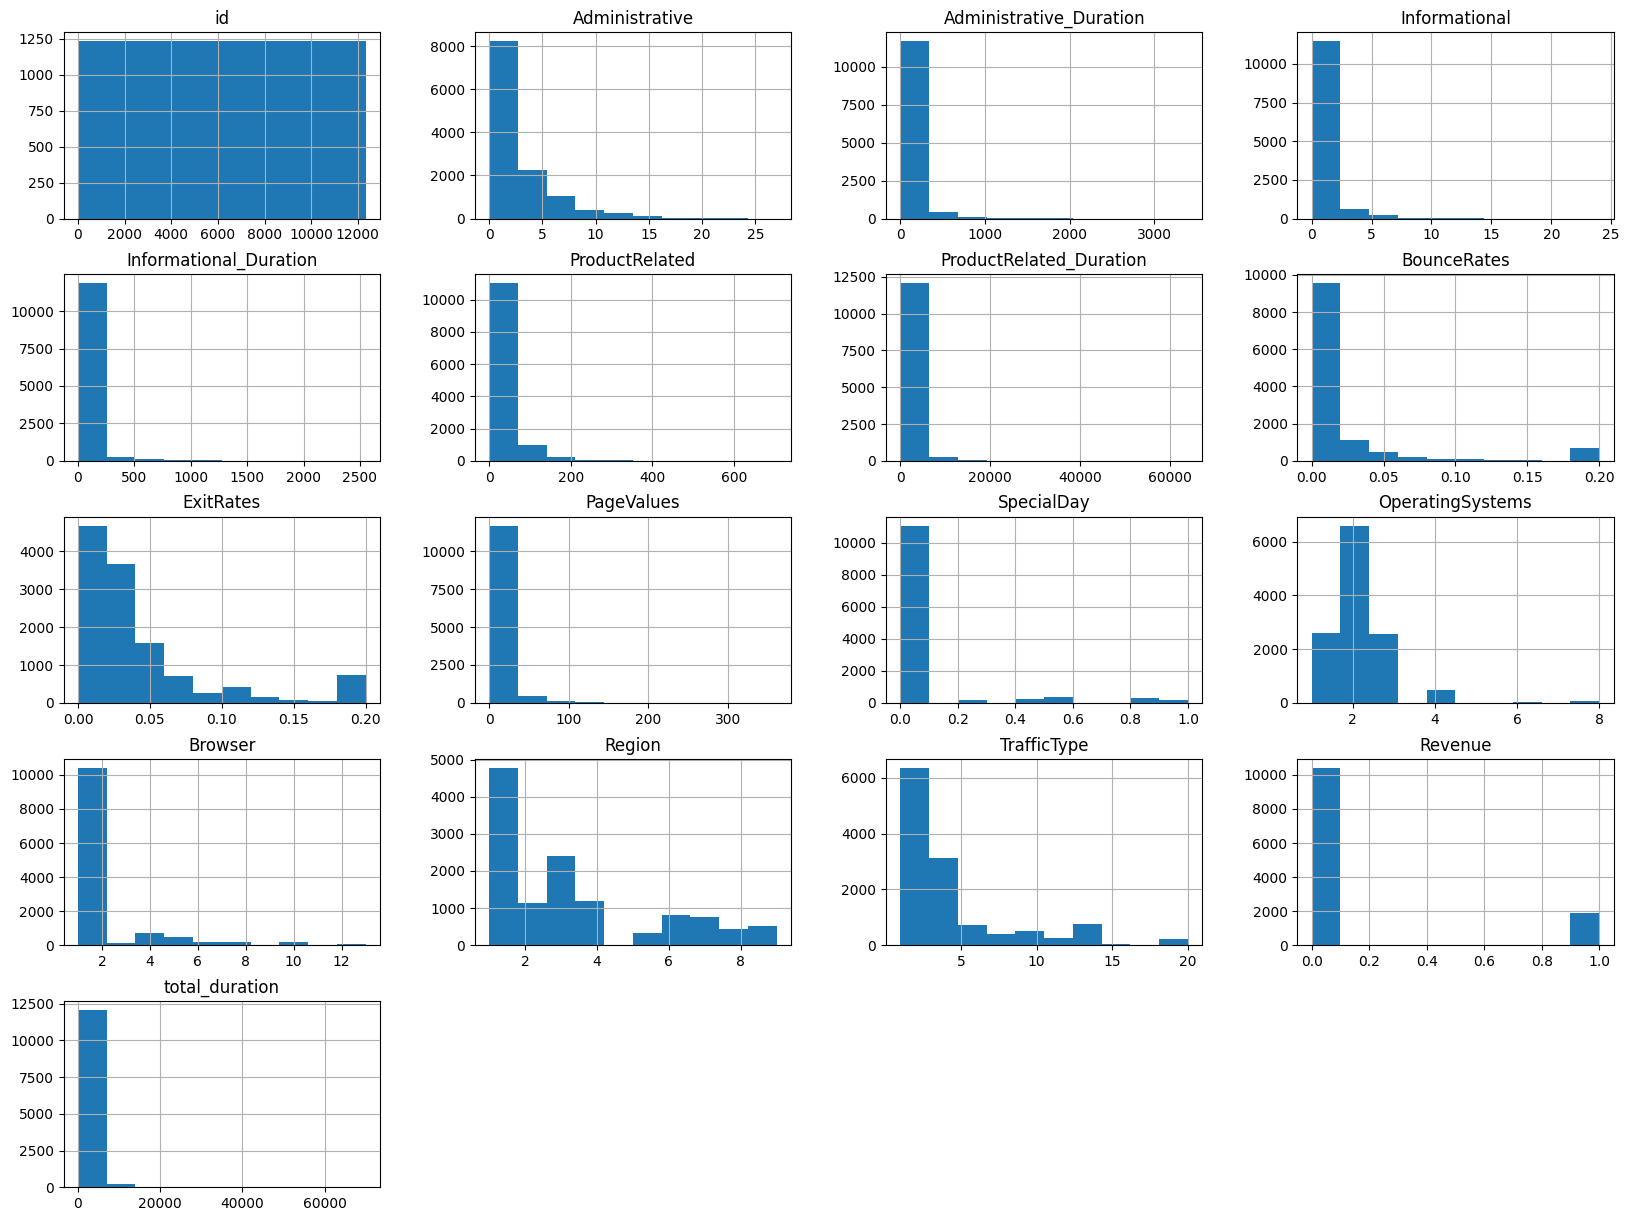

In [15]:
train_df.hist(figsize= (20,15))  #plotting histograms for each column in training data
plt.show()

Do more sessions ends with purchase?

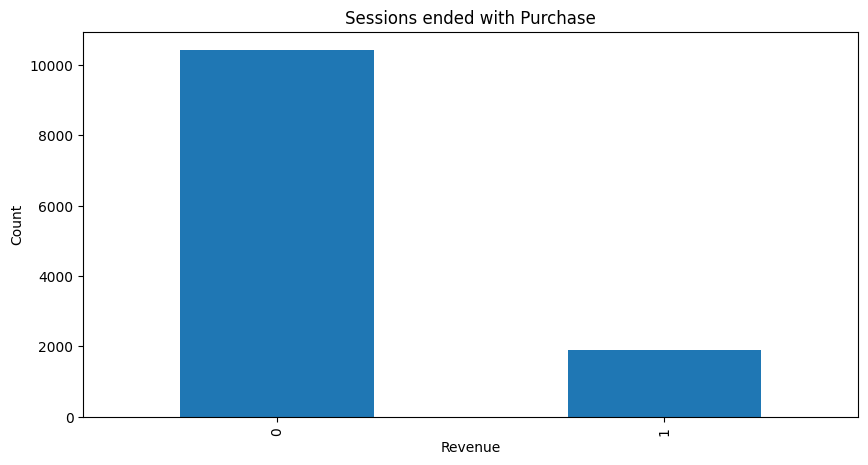

In [16]:
plt.figure(figsize=(10, 5)) #plotting bar plot to show the sessions ended with and without purchase
train_df['Revenue'].value_counts().plot(kind = 'bar')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title('Sessions ended with Purchase')
plt.show()

### Quick review from what we have discover so far

1. We have 18 features, 8 of them are ```object``` type, and the rest of them are numerical (```float```/```int```).
2. Some of the ```duration``` columns are object type (textual, for example: "0.0 minutes"), while other are numerical.
3. There are 12,330 records in train data.
4. The percentage of sessions that end in a purchase is 15.47 %

We will address those insights later.
   

Checking how many missing values there are in every feature

In [17]:
train_df.isna().sum()

id                         0
Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
total_duration             0
dtype: int64

The barplot provides a simple plot where each bar represents a column within the dataframe.

The height of the bar indicates how complete that column is - how many non-null values are present.

It can be generated by calling upon:
In this graph we can see that there are no columns with missing values.

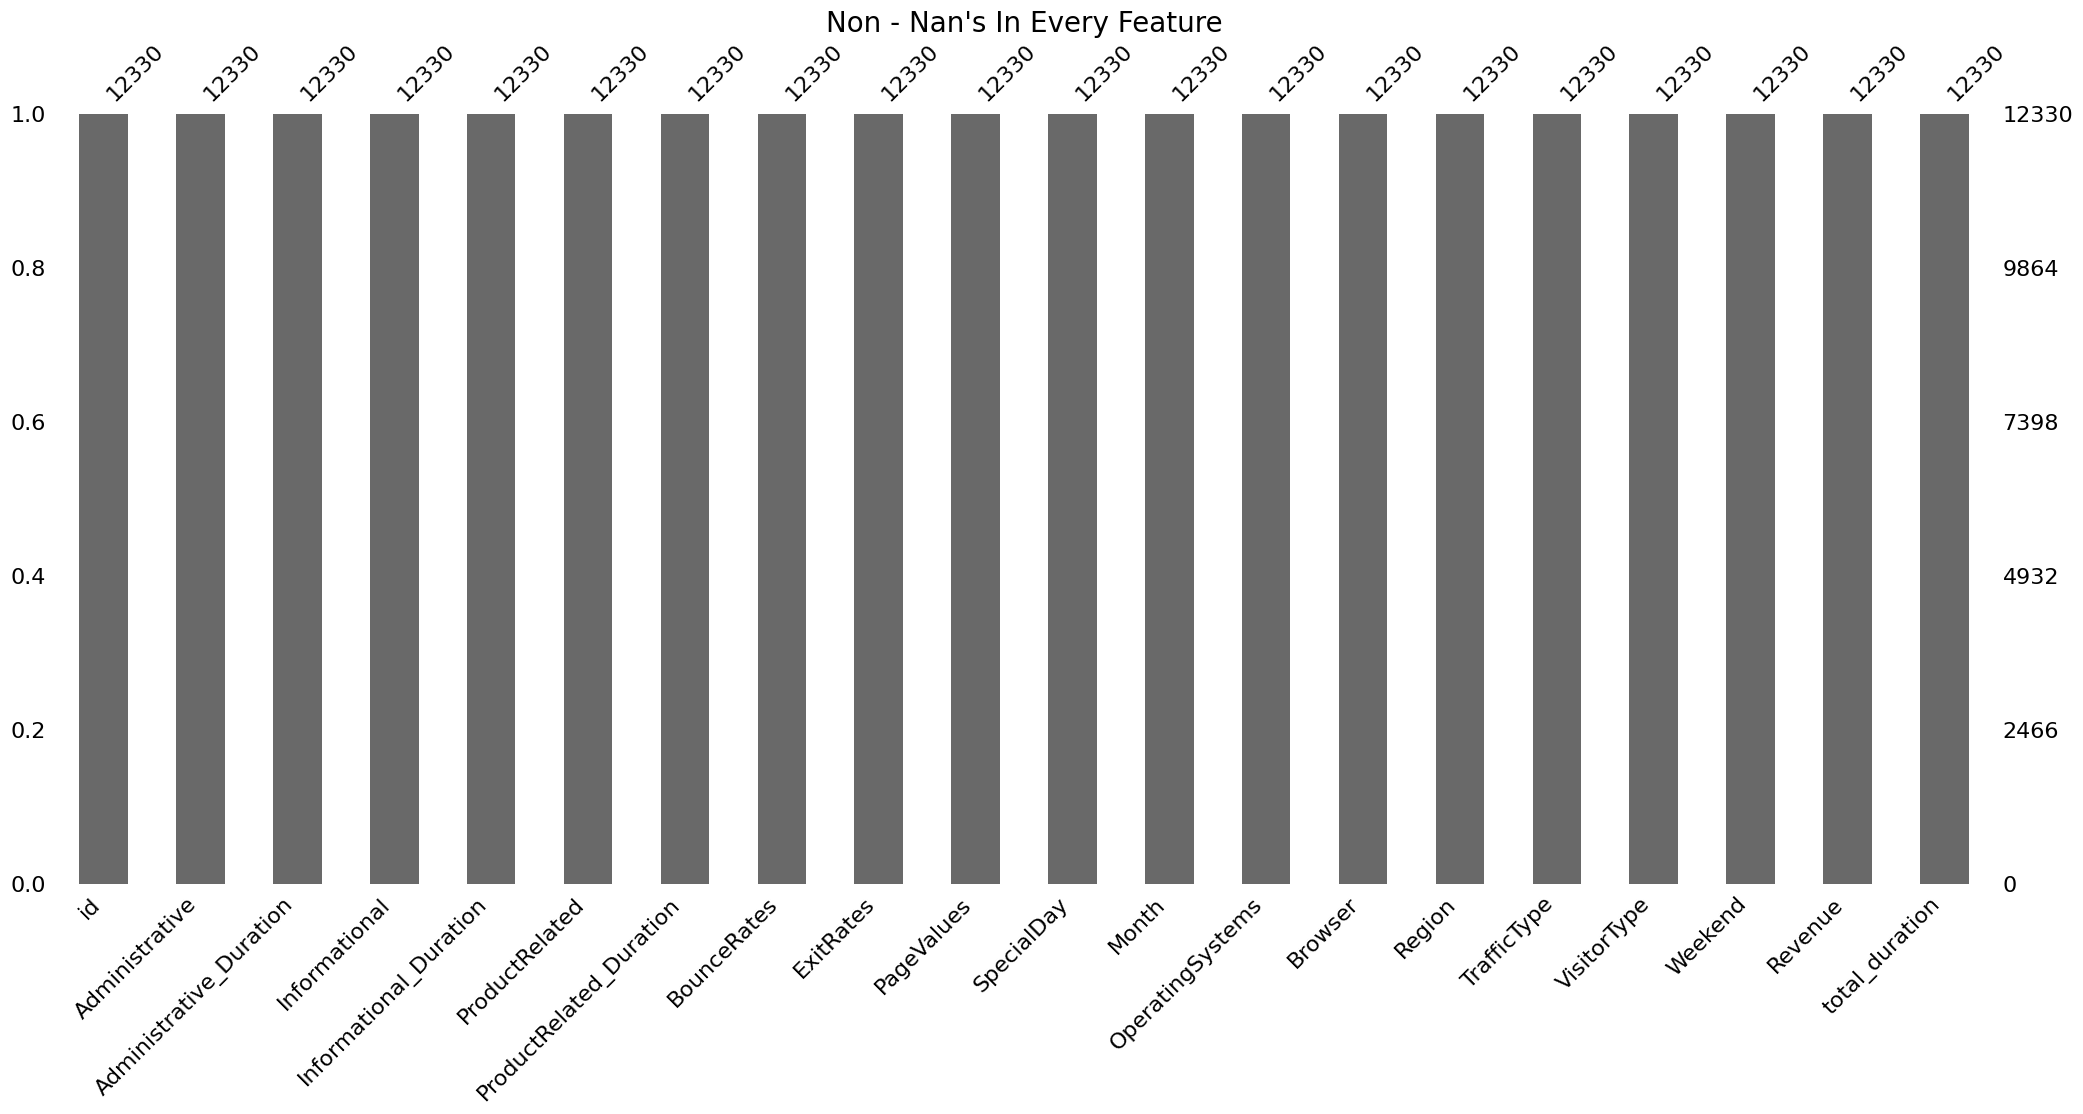

In [18]:
msno.bar(train_df)   #creating to bar plot to show the Non Nan values in each feature
plt.title("Non - Nan's In Every Feature", fontdict={'fontsize':20})
plt.show()

The heatmap is used to identify correlations of the nullity between each of the different columns.

In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.

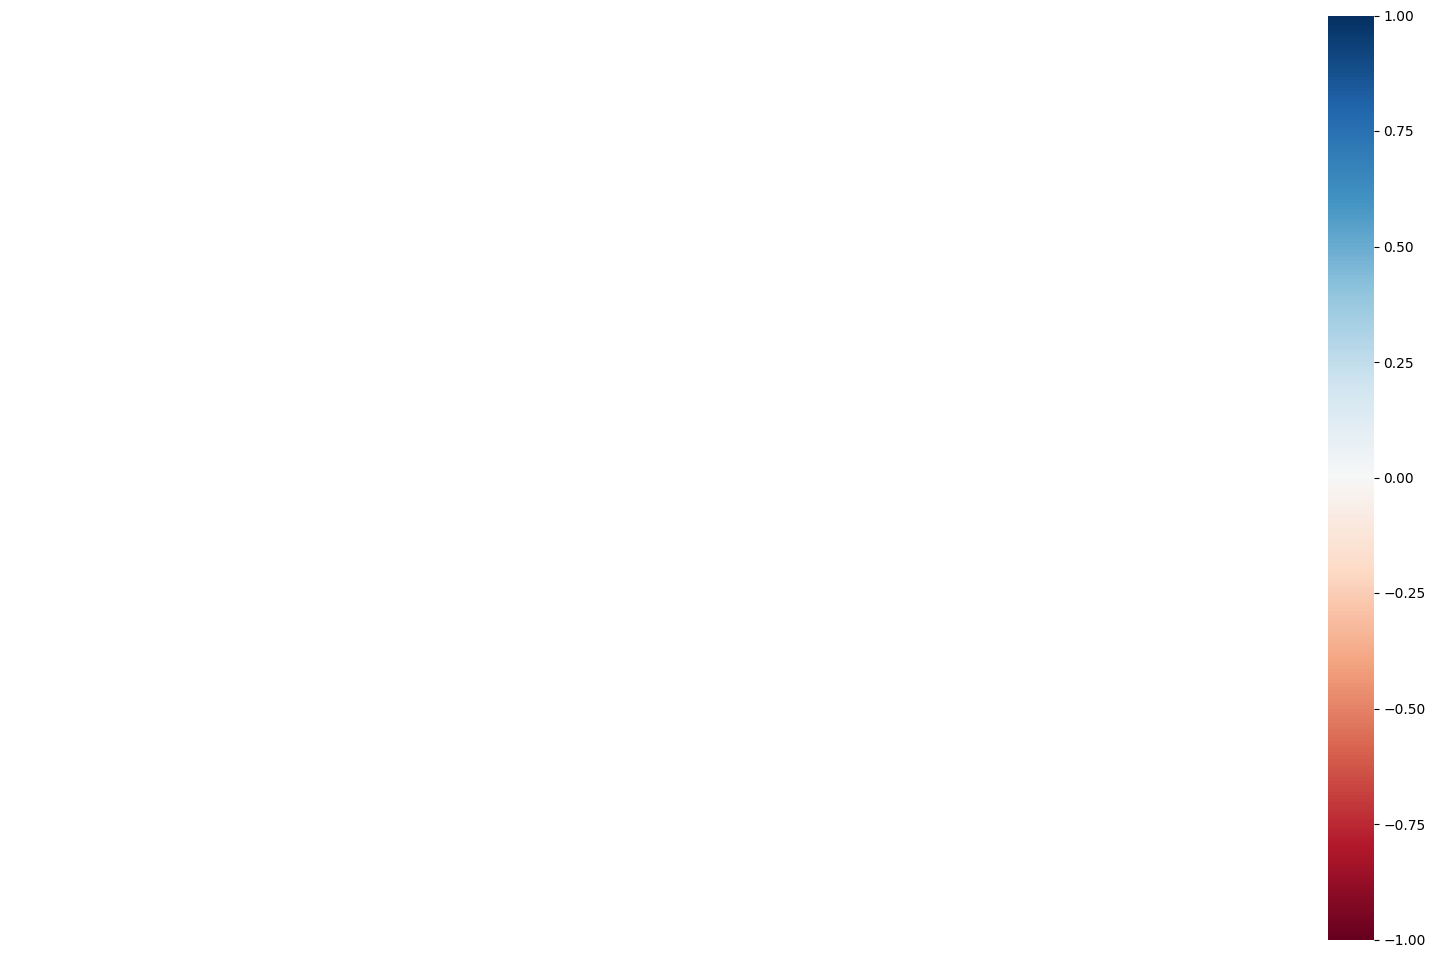

In [19]:
msno.heatmap(train_df)
plt.show()

Let's see how the ```total_duration``` distributes

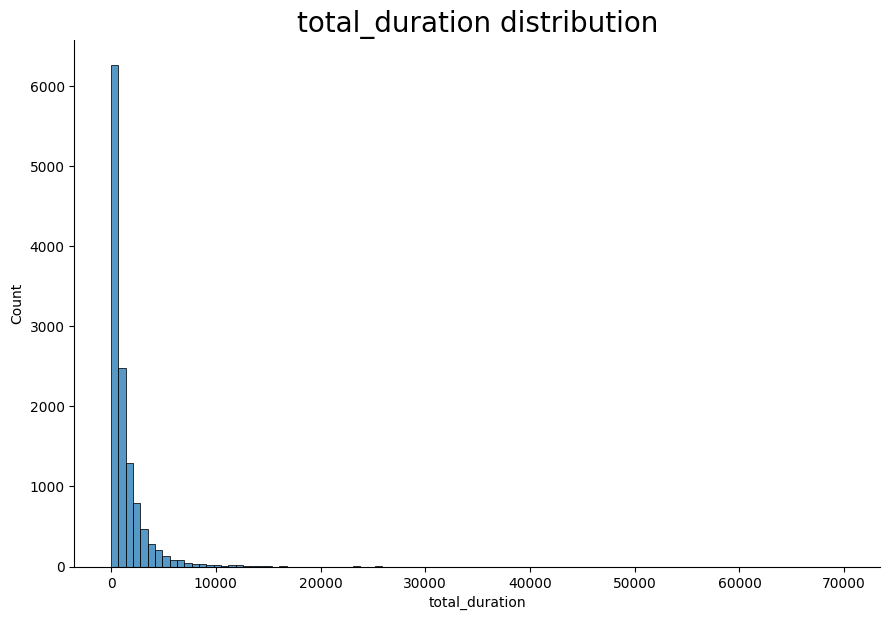

In [20]:
sns.displot(train_df, x=train_df["total_duration"], bins=100, height=6, aspect=1.5)   #creating histogram for total duration with 100 bins
sns.set(font_scale = 1.2)
plt.title('total_duration distribution',  fontdict = {'fontsize':20})
plt.show()

In [21]:
print(f'There are {(train_df["total_duration"] == 0).sum()} zeros in this column which affects the distribution and can be ignored')

There are 720 zeros in this column which affects the distribution and can be ignored


Replacing those zeros with```nan```values

In [22]:
replace_values(train_df, ["total_duration"], 0, np.nan)

As we can see, the majority of the ```total_durtion``` values are between 0 to 12,000. let's zoom in a little..(after ignoring zeros)

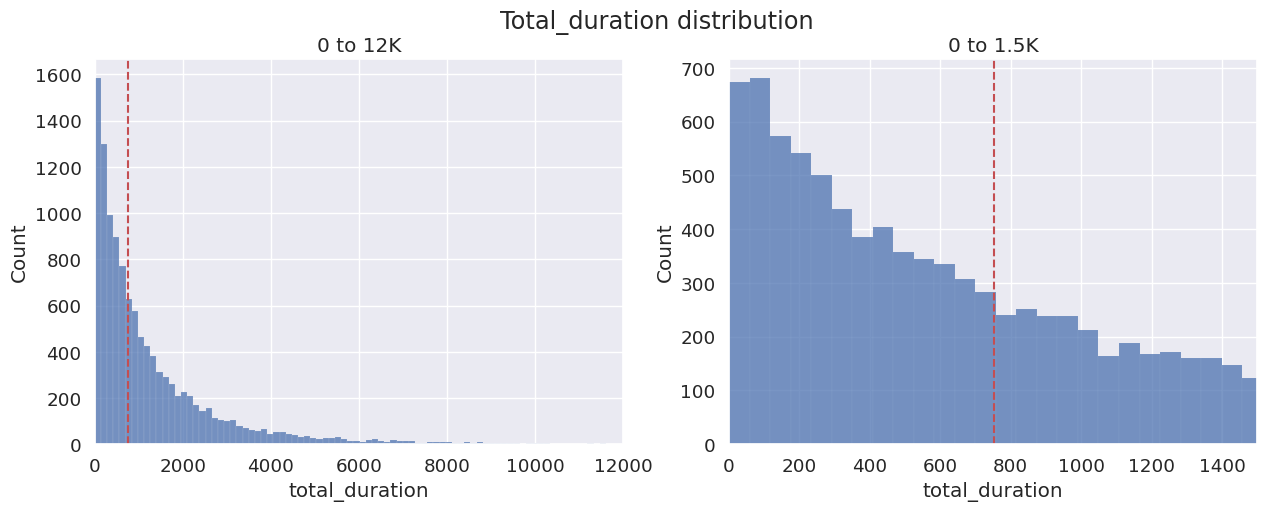

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,5))
axs = axs.ravel()

plt.subplot(1, 2, 1)

fig.suptitle("Total_duration distribution")
#creating a histogram plot for 12000 range with 500 bins
k12 = sns.histplot(data=train_df, x=train_df["total_duration"], bins = 500)
k12.set(xlim =(0, 12000))
plt.title('0 to 12K')
plt.gca().axvline(train_df["total_duration"].median(), color='r', linestyle='--')
#to make it more clear zooming into the histogram creating new one for 1500 range
plt.subplot(1, 2, 2)
plt.title('0 to 1.5K')
second = sns.histplot(data=train_df, x=train_df["total_duration"], bins = 1200)
second.set(xlim =(0, 1500))

plt.gca().axvline(train_df["total_duration"].median(), color='r', linestyle='--')
plt.show()

The dashed red line represents the median of total_duration, a figure which helps us to learn more about this feature. Below may help us in favor of filling in gaps etc.

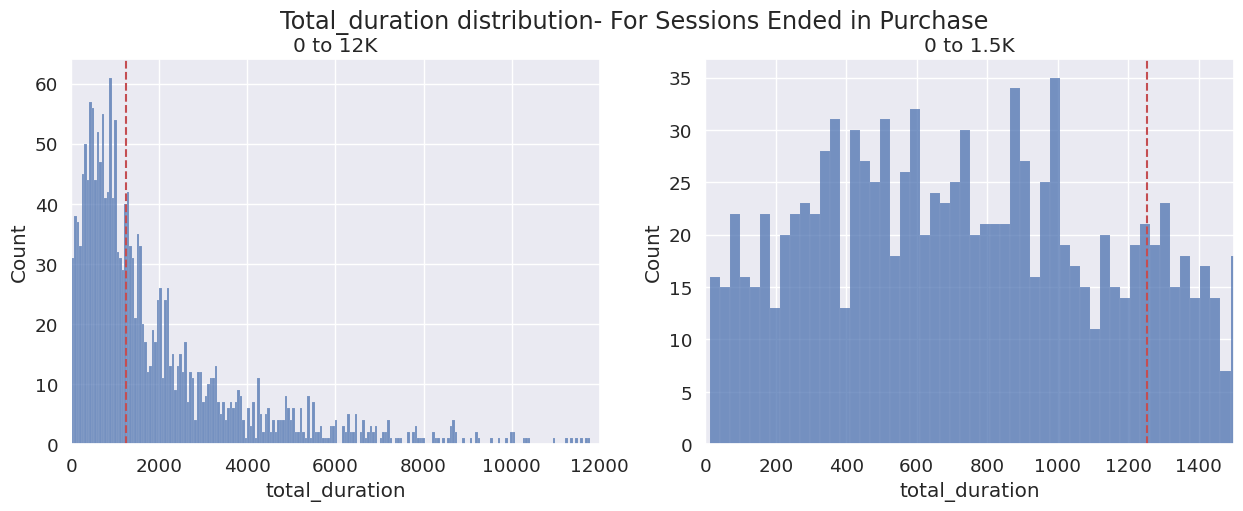

In [24]:
purchases_mask_df = train_df['Revenue'] == 1
purchases_mask_df = train_df[purchases_mask_df]
fig, axs = plt.subplots(nrows = 1, ncols = 2 ,figsize = (15,5))
axs = axs.ravel()

plt.subplot(1, 2, 1)

fig.suptitle("Total_duration distribution- For Sessions Ended in Purchase")
k12 = sns.histplot(data = purchases_mask_df, x = purchases_mask_df["total_duration"], bins = 500)
k12.set(xlim =(0, 12000))

plt.title('0 to 12K')
plt.gca().axvline(purchases_mask_df["total_duration"].median(), color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.title('0 to 1.5K')
second = sns.histplot(data = purchases_mask_df, x = purchases_mask_df["total_duration"], bins = 1000)
second.set(xlim =(0, 1500))

plt.gca().axvline(purchases_mask_df["total_duration"].median(), color='r', linestyle='--')
plt.show()

Most sessions that result in a purchase are between 300 and 900 total duration long.

We will first have to turn ```Informational_Duration``` and ```ProductRelated_Duration``` into floating columns and replace ```minutes``` in each cell in order to examine the density of these columns. During this stage, we will also change the names of the 3 duration columns to include the unit of time

In [25]:
#erase the 'minutes' in those 2 columns + change the number from str to float
train_df['Informational_Duration'] = train_df['Informational_Duration'].astype(str).str.replace('minutes', '')
train_df['ProductRelated_Duration'] = train_df['ProductRelated_Duration'].astype(str).str.replace('minutes', '')

train_df = train_df.astype({'ProductRelated_Duration' : float}, errors='raise')

train_df = train_df.astype({'Informational_Duration' : float}, errors='raise')

# add the unit of time to the columns names
train_df.rename(columns = {'Administrative_Duration': 'Administrative_Duration_min','Informational_Duration': 'Informational_Duration_min', 'ProductRelated_Duration': 'ProductRelated_Duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12330 non-null  int64  
 1   Administrative               12330 non-null  int64  
 2   Administrative_Duration_min  12330 non-null  float64
 3   Informational                12330 non-null  int64  
 4   Informational_Duration_min   12330 non-null  float64
 5   ProductRelated               12330 non-null  int64  
 6   ProductRelated_Duration_min  12330 non-null  float64
 7   BounceRates                  12330 non-null  float64
 8   ExitRates                    12330 non-null  float64
 9   PageValues                   12330 non-null  float64
 10  SpecialDay                   12330 non-null  float64
 11  Month                        12330 non-null  object 
 12  OperatingSystems             12330 non-null  int64  
 13  Browser         

*Comment*
* We have added to the columns describing the durations of the time unit.

  These columns are textual and in the fields a 'minute' appears and from this we understand that it is the unit of time. It is important to say that we think there is an error in the data and that the correct unit of time is seconds.
  
  This is because it seems unlikely to us that a session will last over 1000 minutes (about 16 hours), and there are very many of them.

    However, this will not change the model because later in the work we will normalize all the data, so even if we now divide all 60 of these columns by 60, the normalized columns later will remain the same.

Replacing those zeros with ```nan``` values

In [26]:
replace_values(train_df, ["Informational_Duration_min", "ProductRelated_Duration_min"], 0, np.nan)

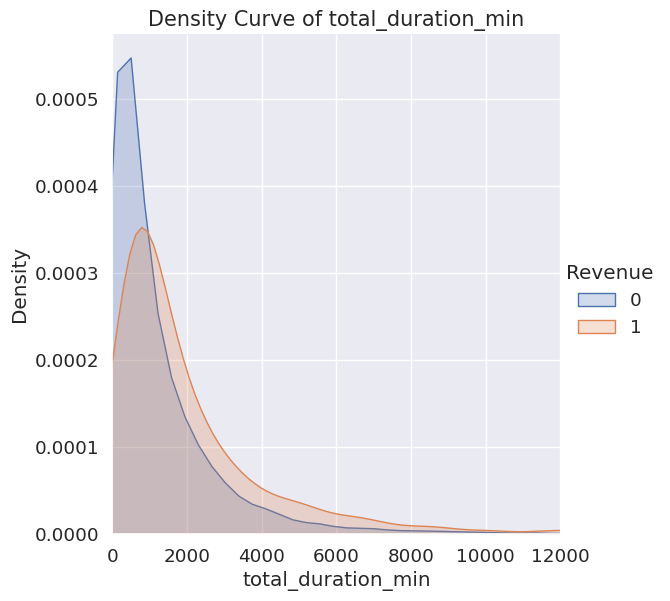

In [27]:
(sns.FacetGrid(train_df, hue="Revenue", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'total_duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of total_duration_min", fontdict = {'fontsize':15})
plt.show()

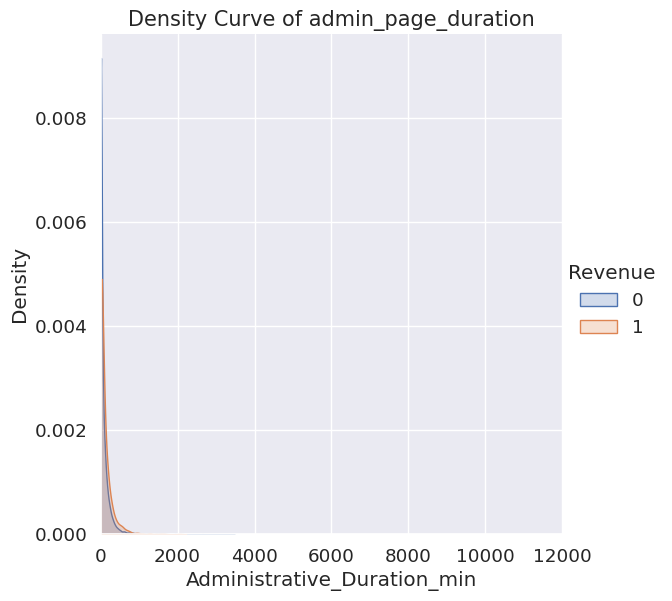

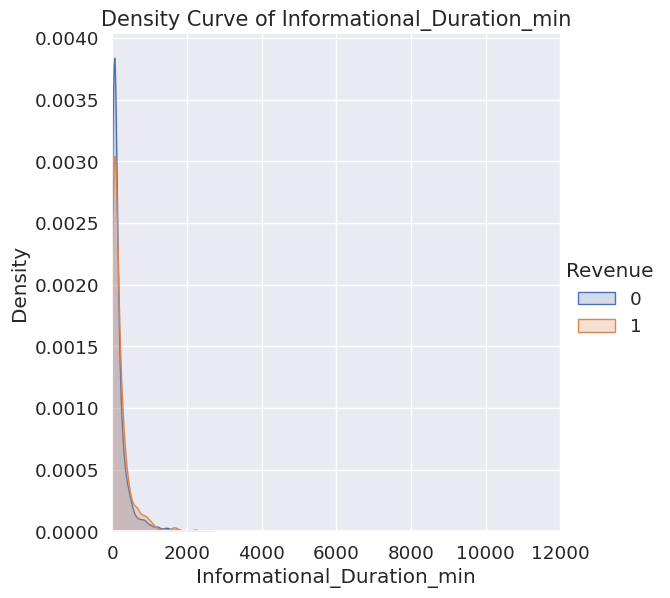

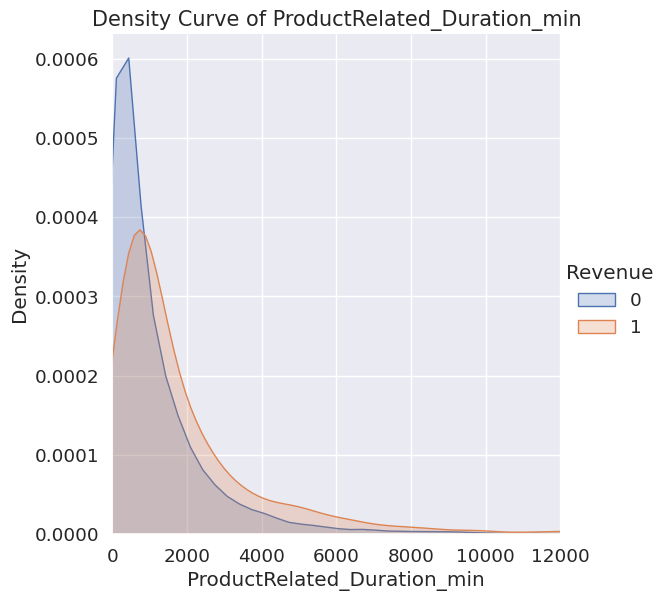

In [28]:
(sns.FacetGrid(train_df, hue="Revenue", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'Administrative_Duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of admin_page_duration", fontdict = {'fontsize':15})

(sns.FacetGrid(train_df, hue="Revenue", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'Informational_Duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of Informational_Duration_min", fontdict = {'fontsize':15})

(sns.FacetGrid(train_df, hue="Revenue", height = 6, xlim = (0,12000))
    .map(sns.kdeplot, 'ProductRelated_Duration_min', shade = True)
    .add_legend());
plt.title("Density Curve of ProductRelated_Duration_min", fontdict = {'fontsize':15})
plt.show()

We can see that the `ProductRelated_Duration_min` feature spreads over a larger range of duration values.

### Correlations between features
(for only numerical variables)

In [29]:
correlations = train_df.corr() #using corr() we are finding the correlation in train data
train_df.corr()

,id,Administrative,Administrative_Duration_min,Informational,Informational_Duration_min,ProductRelated,ProductRelated_Duration_min,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,total_duration_min
id,1.000000,0.078462,0.043120,0.068114,0.035658,0.171057,0.148205,-0.050913,-0.074194,0.049522,-0.226455,0.044963,0.021067,0.012813,0.060139,0.016175,0.121329,0.145142
Administrative,0.078462,1.000000,0.601583,0.376850,0.143517,0.431119,0.356444,-0.223563,-0.316483,0.098990,-0.094778,-0.006347,-0.025035,-0.005487,-0.033561,0.026417,0.138917,0.404679
Administrative_Duration_min,0.043120,0.601583,1.000000,0.302710,0.190572,0.289087,0.344231,-0.144170,-0.205798,0.067608,-0.073304,-0.007343,-0.015392,-0.005561,-0.014376,0.014990,0.093587,0.426982
Informational,0.068114,0.376850,0.302710,1.000000,0.432941,0.374164,0.379183,-0.116114,-0.163666,0.048632,-0.048219,-0.009527,-0.038235,-0.029169,-0.034491,0.035785,0.095200,0.424891
Informational_Duration_min,0.035658,0.143517,0.190572,0.432941,1.000000,0.185182,0.283911,-0.008946,-0.018921,-0.000799,-0.018781,-0.016782,-0.011807,-0.055130,-0.023548,0.000776,0.035721,0.364681
ProductRelated,0.171057,0.431119,0.289087,0.374164,0.185182,1.000000,0.857066,-0.204578,-0.292526,0.056282,-0.023958,0.004290,-0.013146,-0.038122,-0.043064,0.016092,0.158538,0.848850
ProductRelated_Duration_min,0.148205,0.356444,0.344231,0.379183,0.283911,0.857066,1.000000,-0.107416,-0.214063,0.040557,-0.037807,0.004534,-0.007824,-0.033570,-0.031516,0.002477,0.139880,0.993762
BounceRates,-0.050913,-0.223563,-0.144170,-0.116114,-0.008946,-0.204578,-0.107416,1.000000,0.913004,-0.119386,0.072702,0.023823,-0.015772,-0.006485,0.078286,-0.046514,-0.150673,-0.113113
ExitRates,-0.074194,-0.316483,-0.205798,-0.163666,-0.018921,-0.292526,-0.214063,0.913004,1.000000,-0.174498,0.102242,0.014567,-0.004442,-0.008907,0.078616,-0.062587,-0.207071,-0.226166
PageValues,0.049522,0.098990,0.067608,0.048632,-0.000799,0.056282,0.040557,-0.119386,-0.174498,1.000000,-0.063541,0.018508,0.045592,0.011315,0.012532,0.012002,0.492569,0.045686


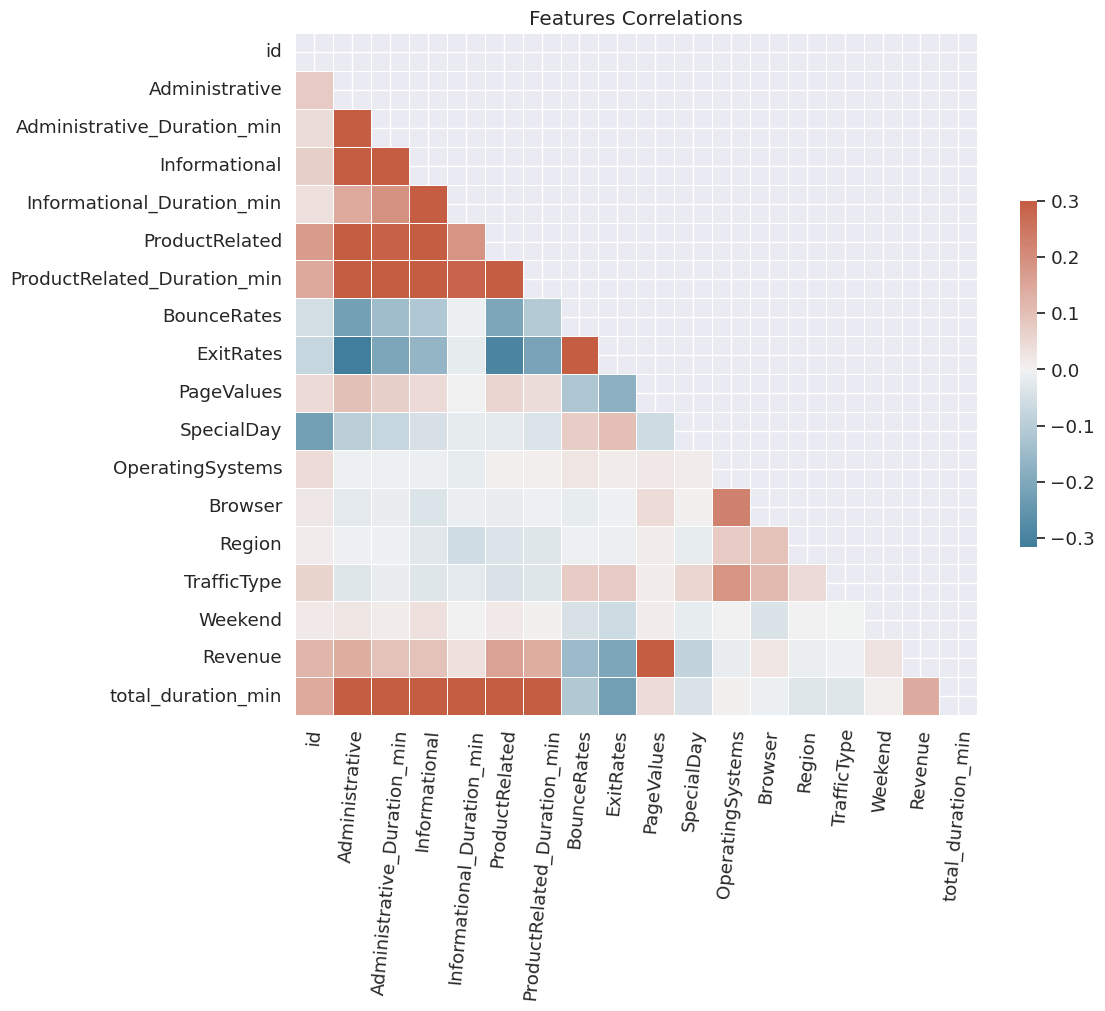

In [30]:
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Features Correlations')
plt.xticks(rotation = 85)
plt.show()

Graphs such as this one allow us to see the correlation between variables.
Once this is identified, we can use it to reduce the dimensions, if two features tell us the same story, we don't need them both.

Dimentionality reduction will be addressed later in this project.

In [31]:
#Strongest 10 correlations
strong_corr = correlations.abs().unstack()
strong_corr[strong_corr != 1].sort_values(kind="quicksort", ascending= False).head(10)

ProductRelated_Duration_min  total_duration_min             0.993762
total_duration_min           ProductRelated_Duration_min    0.993762
ExitRates                    BounceRates                    0.913004
BounceRates                  ExitRates                      0.913004
ProductRelated_Duration_min  ProductRelated                 0.857066
ProductRelated               ProductRelated_Duration_min    0.857066
total_duration_min           ProductRelated                 0.848850
ProductRelated               total_duration_min             0.848850
Administrative_Duration_min  Administrative                 0.601583
Administrative               Administrative_Duration_min    0.601583
dtype: float64

*Correlations we found*

1. Correlation between ```PageValue``` and ```Revenue```. As well as correlation between ```ExitRate``` and ```BounceRate```.
2. Correlation between ```D``` and ```Revenue```.
3. No correlation between ```ProductRelated``` and ```OperatingSystems```.

Examine the strongest correlation we have (between ```BounceRates``` and ```ExitRates```)

In [32]:
fig = px.scatter(train_df, x='total_duration_min', y="ProductRelated_Duration_min", trendline="ols", \
                 trendline_color_override="red", title = 'The Strongest Correlation')
fig.show()

### Distribution of Purchases by Month
1. We can see that 2 months are missing - January and April, in those months there were no sessions, or just this is a situation of missing data.
2. Easy to see that November is the month were the purchase rate is the highest.

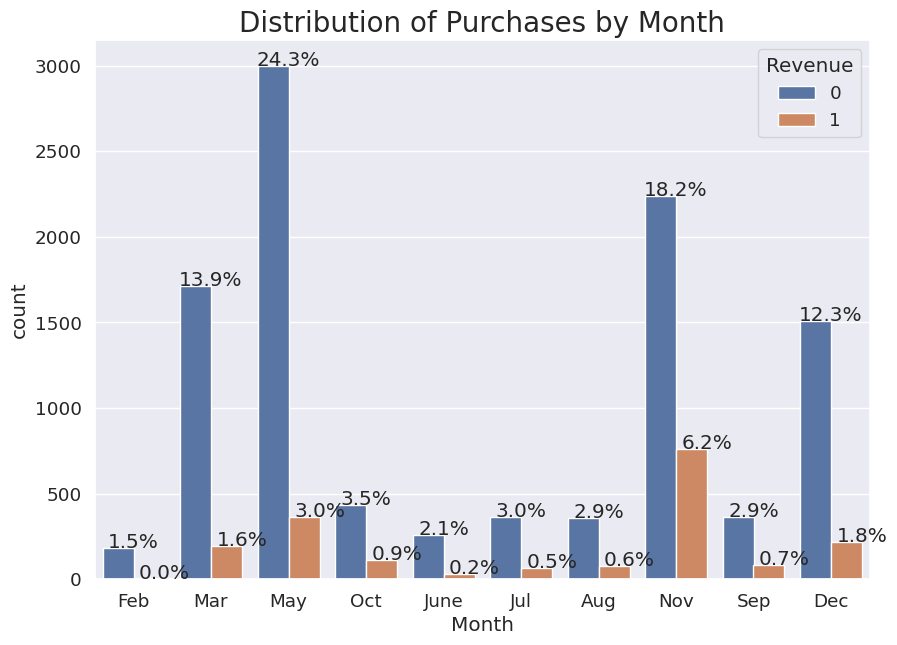

In [33]:
plt.figure(figsize = (10,7))
plt.title("Distribution of Purchases by Month", fontdict = {'fontsize':20})
ax = sns.countplot(x = "Month", hue = 'Revenue', data = train_df)
total = float(len(train_df))
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

Let's look at each month individually

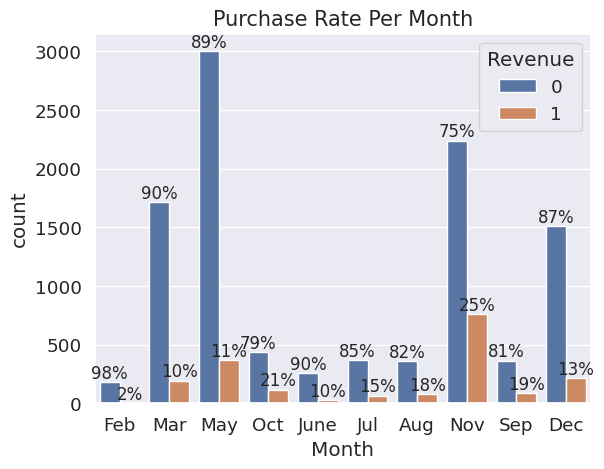

In [34]:
ax = sns.countplot(x = "Month", hue = 'Revenue', data = train_df)
sns.set(rc = {'figure.figsize':(10,7)})
barPerc(train_df, 'Month', ax)
plt.title('Purchase Rate Per Month',fontdict = {'fontsize':15})
plt.show()

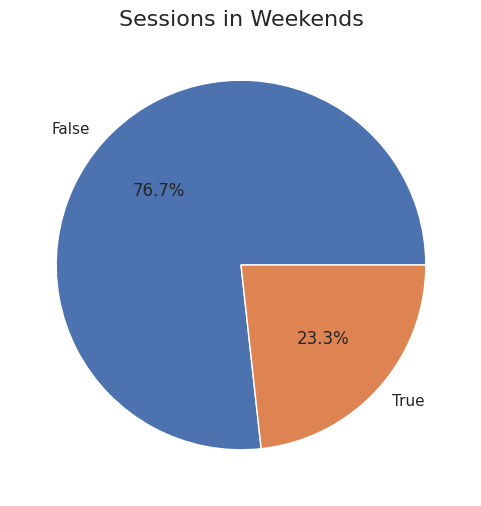

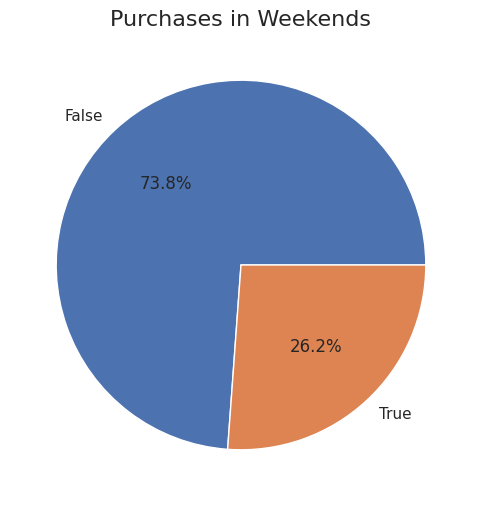

In [35]:
purchase_mask = train_df.Revenue == 1
train_df.groupby('Weekend').size().plot.pie(subplots=True,autopct='%1.1f%%', figsize=(11, 6))
plt.title("Sessions in Weekends", fontdict= {'fontsize':16})
plt.ylabel("")
plt.show()
train_df[purchase_mask].groupby('Weekend').size().plot.pie(subplots=True,autopct='%1.1f%%', figsize=(11, 6))
plt.title("Purchases in Weekends", fontdict= {'fontsize':16})
plt.ylabel("")
plt.show()

In [36]:
weekend_prec_in_week = ((2/7)*100)

print(f'We expected to get at least: {round(((2/7)*100), 2)} % of session in weekends, which demonstrate the amount of days in weekend (2) out of 7 days a week, it is interesting to see that this precentage is actually lower')

We expected to get at least: 28.57 % of session in weekends, which demonstrate the amount of days in weekend (2) out of 7 days a week, it is interesting to see that this precentage is actually lower


# Preprocessing

## Filling Missing Values

In [37]:
train_df.isna().sum()

id                                0
Administrative                    0
Administrative_Duration_min       0
Informational                     0
Informational_Duration_min     9925
ProductRelated                    0
ProductRelated_Duration_min     755
BounceRates                       0
ExitRates                         0
PageValues                        0
SpecialDay                        0
Month                             0
OperatingSystems                  0
Browser                           0
Region                            0
TrafficType                       0
VisitorType                       0
Weekend                           0
Revenue                           0
total_duration_min              720
dtype: int64

Now we will take care of missing values in the duration columns, we saw at the section that there is high positive correlation between the number of pages to the duration of the related pages.

Filling missing valus in the 3 pairs of columns we have, Using the `find_zeros_and_replace` func we wrote, see documentation in the 'functions' section.
1. **```Administrative``` & ```Administrative_Duration_min```**
2. **`Informational` & `Informational_Duration_min`**
3. **`Informational` & `Informational_Duration_min`**

**```Administrative``` & ```Administrative_Duration_min```**

In [38]:
admin_p_num_nans = train_df['Administrative'].isna().sum()
admin_p_dur_nans = train_df['Administrative_Duration_min'].isna().sum()

print(f'Current number of nan in Administrative column is: {admin_p_num_nans}')
print(f'Current number of nan in Administrative_Duration_min column is: {admin_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'Administrative_Duration_min', 'Administrative')

admin_p_num_nans = train_df['Administrative'].isna().sum()
admin_p_dur_nans = train_df['Administrative_Duration_min'].isna().sum()

print(f'Current number of nan in Administrative column is: {admin_p_num_nans}')
print(f'Current number of nan in Administrative_Duration_min column is: {admin_p_dur_nans}')

Current number of nan in Administrative column is: 0
Current number of nan in Administrative_Duration_min column is: 0
now use the func..
Current number of nan in Administrative column is: 0
Current number of nan in Administrative_Duration_min column is: 0


**`Informational` & `Informational_Duration_min`**

In [39]:
info_p_num_nans = train_df['Informational'].isna().sum()
info_p_dur_nans = train_df['Informational_Duration_min'].isna().sum()

print(f'Current number of nan in Informational column is: {info_p_num_nans}')
print(f'Current number of nan in Informational_Duration_min column is: {info_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'Informational_Duration_min', 'Informational')

info_p_num_nans = train_df['Administrative'].isna().sum()
info_p_dur_nans = train_df['Informational_Duration_min'].isna().sum()

print(f'Current number of nan in Informational column is: {info_p_num_nans}')
print(f'Current number of nan in Informational_Duration_min column is: {info_p_dur_nans}')

Current number of nan in Informational column is: 0
Current number of nan in Informational_Duration_min column is: 9925
now use the func..
Current number of nan in Informational column is: 0
Current number of nan in Informational_Duration_min column is: 226


**`ProductRelated` & `ProductRelated_Duration_min`**

In [40]:
product_p_num_nans = train_df['ProductRelated'].isna().sum()
product_p_dur_nans = train_df['ProductRelated_Duration_min'].isna().sum()

print(f'Current number of nan in ProductRelated column is: {product_p_num_nans}')
print(f'Current number of nan in ProductRelated_Duration_min column is: {product_p_dur_nans}')
print('now use the func..')

find_zeros_and_replace(train_df, 'ProductRelated_Duration_min', 'ProductRelated')

product_p_num_nans = train_df['ProductRelated'].isna().sum()
product_p_dur_nans = train_df['ProductRelated_Duration_min'].isna().sum()

print(f'Current number of nan in ProductRelated column is: {product_p_num_nans}')
print(f'Current number of nan in ProductRelated_Duration_min column is: {product_p_dur_nans}')

Current number of nan in ProductRelated column is: 0
Current number of nan in ProductRelated_Duration_min column is: 755
now use the func..
Current number of nan in ProductRelated column is: 0
Current number of nan in ProductRelated_Duration_min column is: 717


Dropping records with a lot of missing values - We decided to set the threshold at 5.

In [41]:
train_df.shape[0]

12330

In [42]:
train_df = remove_records_with_many_nans(train_df, 5) # we deleted 54 records

In [43]:
train_df.shape[0]

12330

In [44]:
train_df.isna().sum() #We will now go and check how many missing values we have left and we will take care of them

id                               0
Administrative                   0
Administrative_Duration_min      0
Informational                    0
Informational_Duration_min     226
ProductRelated                   0
ProductRelated_Duration_min    717
BounceRates                      0
ExitRates                        0
PageValues                       0
SpecialDay                       0
Month                            0
OperatingSystems                 0
Browser                          0
Region                           0
TrafficType                      0
VisitorType                      0
Weekend                          0
Revenue                          0
total_duration_min             720
dtype: int64

Check if there is a nullity correlation, in order to determine if there is something behind those missing values.

We have created a new data with 6 columns that have missing values, each column is Boolean. For a row that has a missing value we put the value 1, otherwise 0. We then checked the correlation between the columns in this new data.

In [45]:
train_df_check_nan_corr= train_df.copy()

A new bool column will be added where 0 means there is no missing value, 1 means there is nan in the corresponding record.

We will add this new column to each of those exsisting columns:

1. Administrative
2. Administrative_Duration_min
3. Informational
4. Informational_Duration_min
5. ProductRelated
6. ProductRelated_Duration_min

In [46]:
train_df_check_nan_corr['Administrative_nan'] = train_df_check_nan_corr[['Administrative']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['Administrative_Duration_min_nan'] = train_df_check_nan_corr[['Administrative_Duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['Informational_nan'] = train_df_check_nan_corr[['Informational']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['Informational_Duration_min_nan'] = train_df_check_nan_corr[['Informational_Duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['ProductRelated_nan'] = train_df_check_nan_corr[['ProductRelated']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)
train_df_check_nan_corr['ProductRelated_Duration_min_nan'] = train_df_check_nan_corr[['ProductRelated_Duration_min']].isna().sum(axis=1).apply(lambda x: 0 if x==0 else 1)

In [47]:
train_df_check_nan_corr.shape

(12330, 26)

In [48]:
train_df_check_nan_corr.drop(train_df_check_nan_corr.columns[0:22], axis=1, inplace=True) # dropping the 'old' columns

In [49]:
train_df_check_nan_corr.shape

(12330, 4)

In [50]:
train_df_check_nan_corr.columns

Index(['Informational_nan', 'Informational_Duration_min_nan',
       'ProductRelated_nan', 'ProductRelated_Duration_min_nan'],
      dtype='object')

Let's now check the correlations

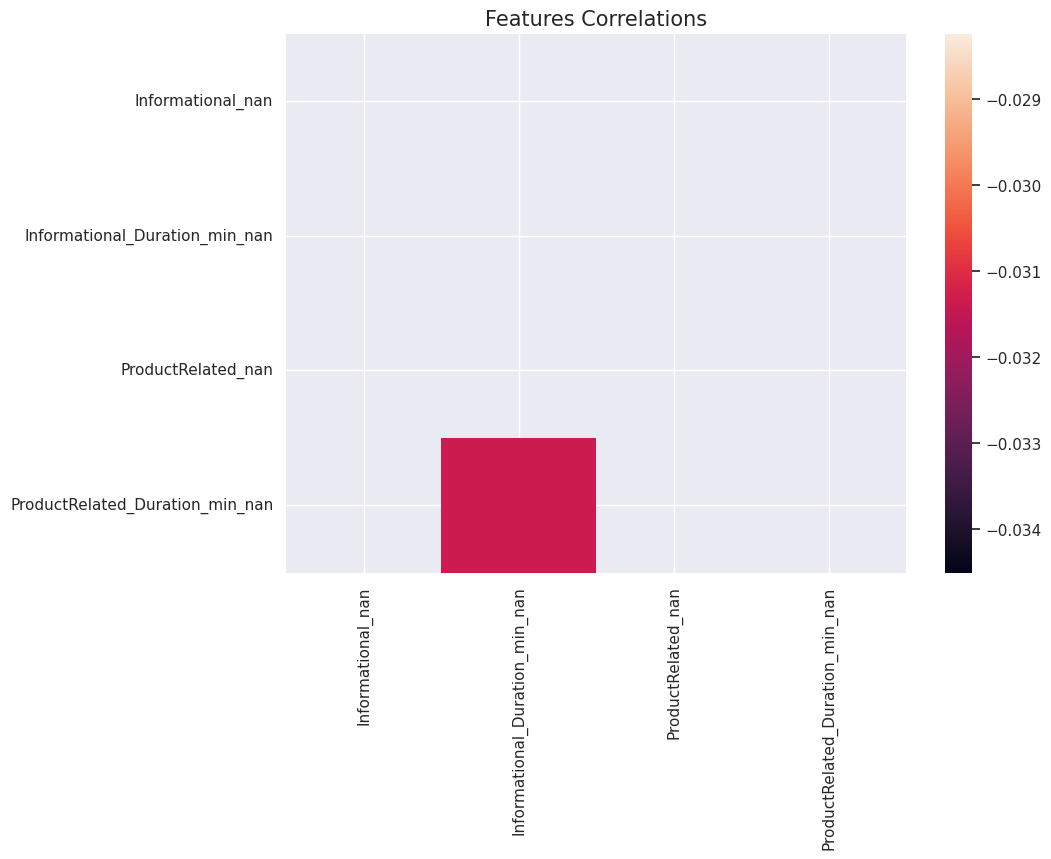

In [51]:
correlations = train_df_check_nan_corr.corr()
plt.title('Features Correlations', fontdict = {'fontsize':15})
mask_ut = np.triu(np.ones(correlations.shape)).astype(np.bool)
hmap = sns.heatmap(correlations, mask=mask_ut)
plt.show()

As we can see, there is no correlation between any of those new bollian columns, except for the `Informational_nan` that has strong correlation to `Informational_Duration_min_nan`.

We conclude that the missing values in the columns:

1. Administrative
2. Administrative_Duration_min
3. ProductRelated
4. ProductRelated_Duration_min

can be replaced with some mean / median / constant value, which will not cause a certain bias.

Filling missing values with the mean values

In [52]:
columns_list = ['Administrative','Administrative_Duration_min','ProductRelated','ProductRelated_Duration_min']
for col in columns_list:
    train_df[col].fillna(value = train_df[col].mean(axis = 0, skipna = True), inplace = True)

let's fill the missing values in 'info_page_duration_min' feature

In [53]:
train_df['Informational_Duration_min'].value_counts()

0.00      9699
9.00        33
7.00        26
10.00       26
6.00        26
          ... 
246.80       1
274.00       1
13.40        1
223.15       1
211.25       1
Name: Informational_Duration_min, Length: 1258, dtype: int64

The vast majority of the values for this feature are zeros, so it was decided that the missing values would be replaced with zeros (the most frequent value).

In [54]:
replace_values(train_df, ['Informational_Duration_min'], np.nan, 0)

In [55]:
train_df['Informational_Duration_min'].isna().sum() # now we do not have missing values in that feature

0

In [56]:
total_dur_nans = train_df['total_duration_min'].isna().sum()
print(f'Now that we have no missing values in the durations columns, lets fill the {total_dur_nans} missing values in the total_duration column by \n summning all other duration columns')

Now that we have no missing values in the durations columns, lets fill the 720 missing values in the total_duration column by 
 summning all other duration columns


In [57]:
train_df['total_duration_min'] = train_df['Informational_Duration_min'] + train_df['ProductRelated_Duration_min'] + train_df['Administrative_Duration_min']

In [58]:
total_dur_nans = train_df['total_duration_min'].isna().sum()
print(f'Now we have {total_dur_nans} missing values in the total_durations column')

Now we have 0 missing values in the total_durations column


Dealing with 'SpecialDay' feature missing values

In [59]:
closeness_median = train_df['SpecialDay'].median()
closeness_mean =  train_df['SpecialDay'].mean()
print(f'The median of this colimns is: {closeness_median} \n While the mean is: {closeness_mean}')
# filling closeness_to_holiday with the mean
train_df['SpecialDay'].fillna(value = train_df.SpecialDay.mean(axis = 0, skipna = True), inplace=True)

The median of this colimns is: 0.0 
 While the mean is: 0.061427412814274135


Dealing with 'OperatingSystems' feature missing values

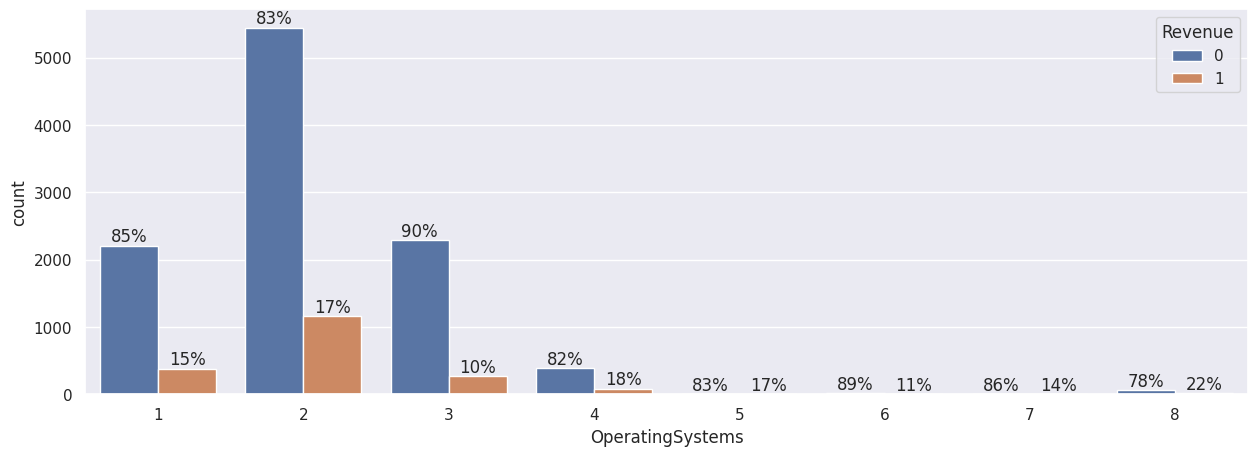

In [60]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x = 'OperatingSystems',hue = 'Revenue',data = train_df)
barPerc(train_df, 'OperatingSystems', ax)
plt.show()

In [61]:
device_mean = train_df['OperatingSystems'].mean()
device_median = train_df['OperatingSystems'].median()

print(f'The OperatingSystems mean is: {round(device_mean, 3)}, while the median is: {device_median}')

The OperatingSystems mean is: 2.124, while the median is: 2.0


In [62]:
# lets see the frequent of every value
train_df['OperatingSystems'].value_counts()

2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: OperatingSystems, dtype: int64

The values represented by numbers are irrelevant since this feature describes the device used by the user for the session. We therefore decided to fill in the missing value with the most frequent value.

Fill all missing values with the most frequent value of each feature

In [63]:
train_df

,id,Administrative,Administrative_Duration_min,Informational,Informational_Duration_min,ProductRelated,ProductRelated_Duration_min,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,total_duration_min
0,1,0,0.0,0,0.0,1,1268.511228,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,0,1268.511228
1,2,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,0,64.000000
2,3,0,0.0,0,0.0,1,1268.511228,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,0,1268.511228
3,4,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,0,2.666667
4,5,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,0,627.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,12326,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,0,1928.791667
12326,12327,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,0,465.750000
12327,12328,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,0,184.250000
12328,12329,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,0,421.000000


We see that there are alot of browsers versions, lets see how many browsers types there are

In [64]:
num_types_internet_browsers = train_df.groupby('Browser').size().shape[0]
print(f'We have: {num_types_internet_browsers} different types of internet browsers')

We have: 13 different types of internet browsers


As part of the next phase of this work (relating to categories of features), we will remove the versions and maintain only the type of browser.

We won't care about the browser version since we have many different versions that don't matter to us, so we'll get rid of the versions.

In [65]:
train_df.groupby('Browser').size().shape[0]

13

Also can be seen- we started with 126 browser types, now we have only 14 of them (and after filling the missing values we will have 13)

In [66]:
print(f"Finally, we have no missing values in the train_df, right? Answer -> {(train_df.isna().sum() == 0).all()}")

Finally, we have no missing values in the train_df, right? Answer -> True


In [67]:
train_df['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

> ####  Feature Engineering

As part of the feature engineering stage, we create a new column for the year season.  
The seasons are defined as spring (March, April, May), summer (June, July, August), fall (September, October, November), and winter (December, January, February).

In [68]:
season_dict = {'Jan': 'Winter',
               'Feb': 'Winter',
               'Mar': 'Spring',
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'Jul': 'Summer',
               'Aug': 'Summer',
               'Sep': 'Fall',
               'Oct': 'Fall',
               'Nov': 'Fall',
               'Dec': 'Winter'}

train_df['Season'] = train_df['Month'].apply(lambda x: season_dict[x]) # insert the new column

Also as part of the feature engineering stage we will turn the `Weekend` into boolean.

## Dealing With Outliers

In [69]:
records_num_before_removing_outliers = train_df.shape[0]
print(f'Before removing outliers we have {records_num_before_removing_outliers} records in the train data')

Before removing outliers we have 12330 records in the train data


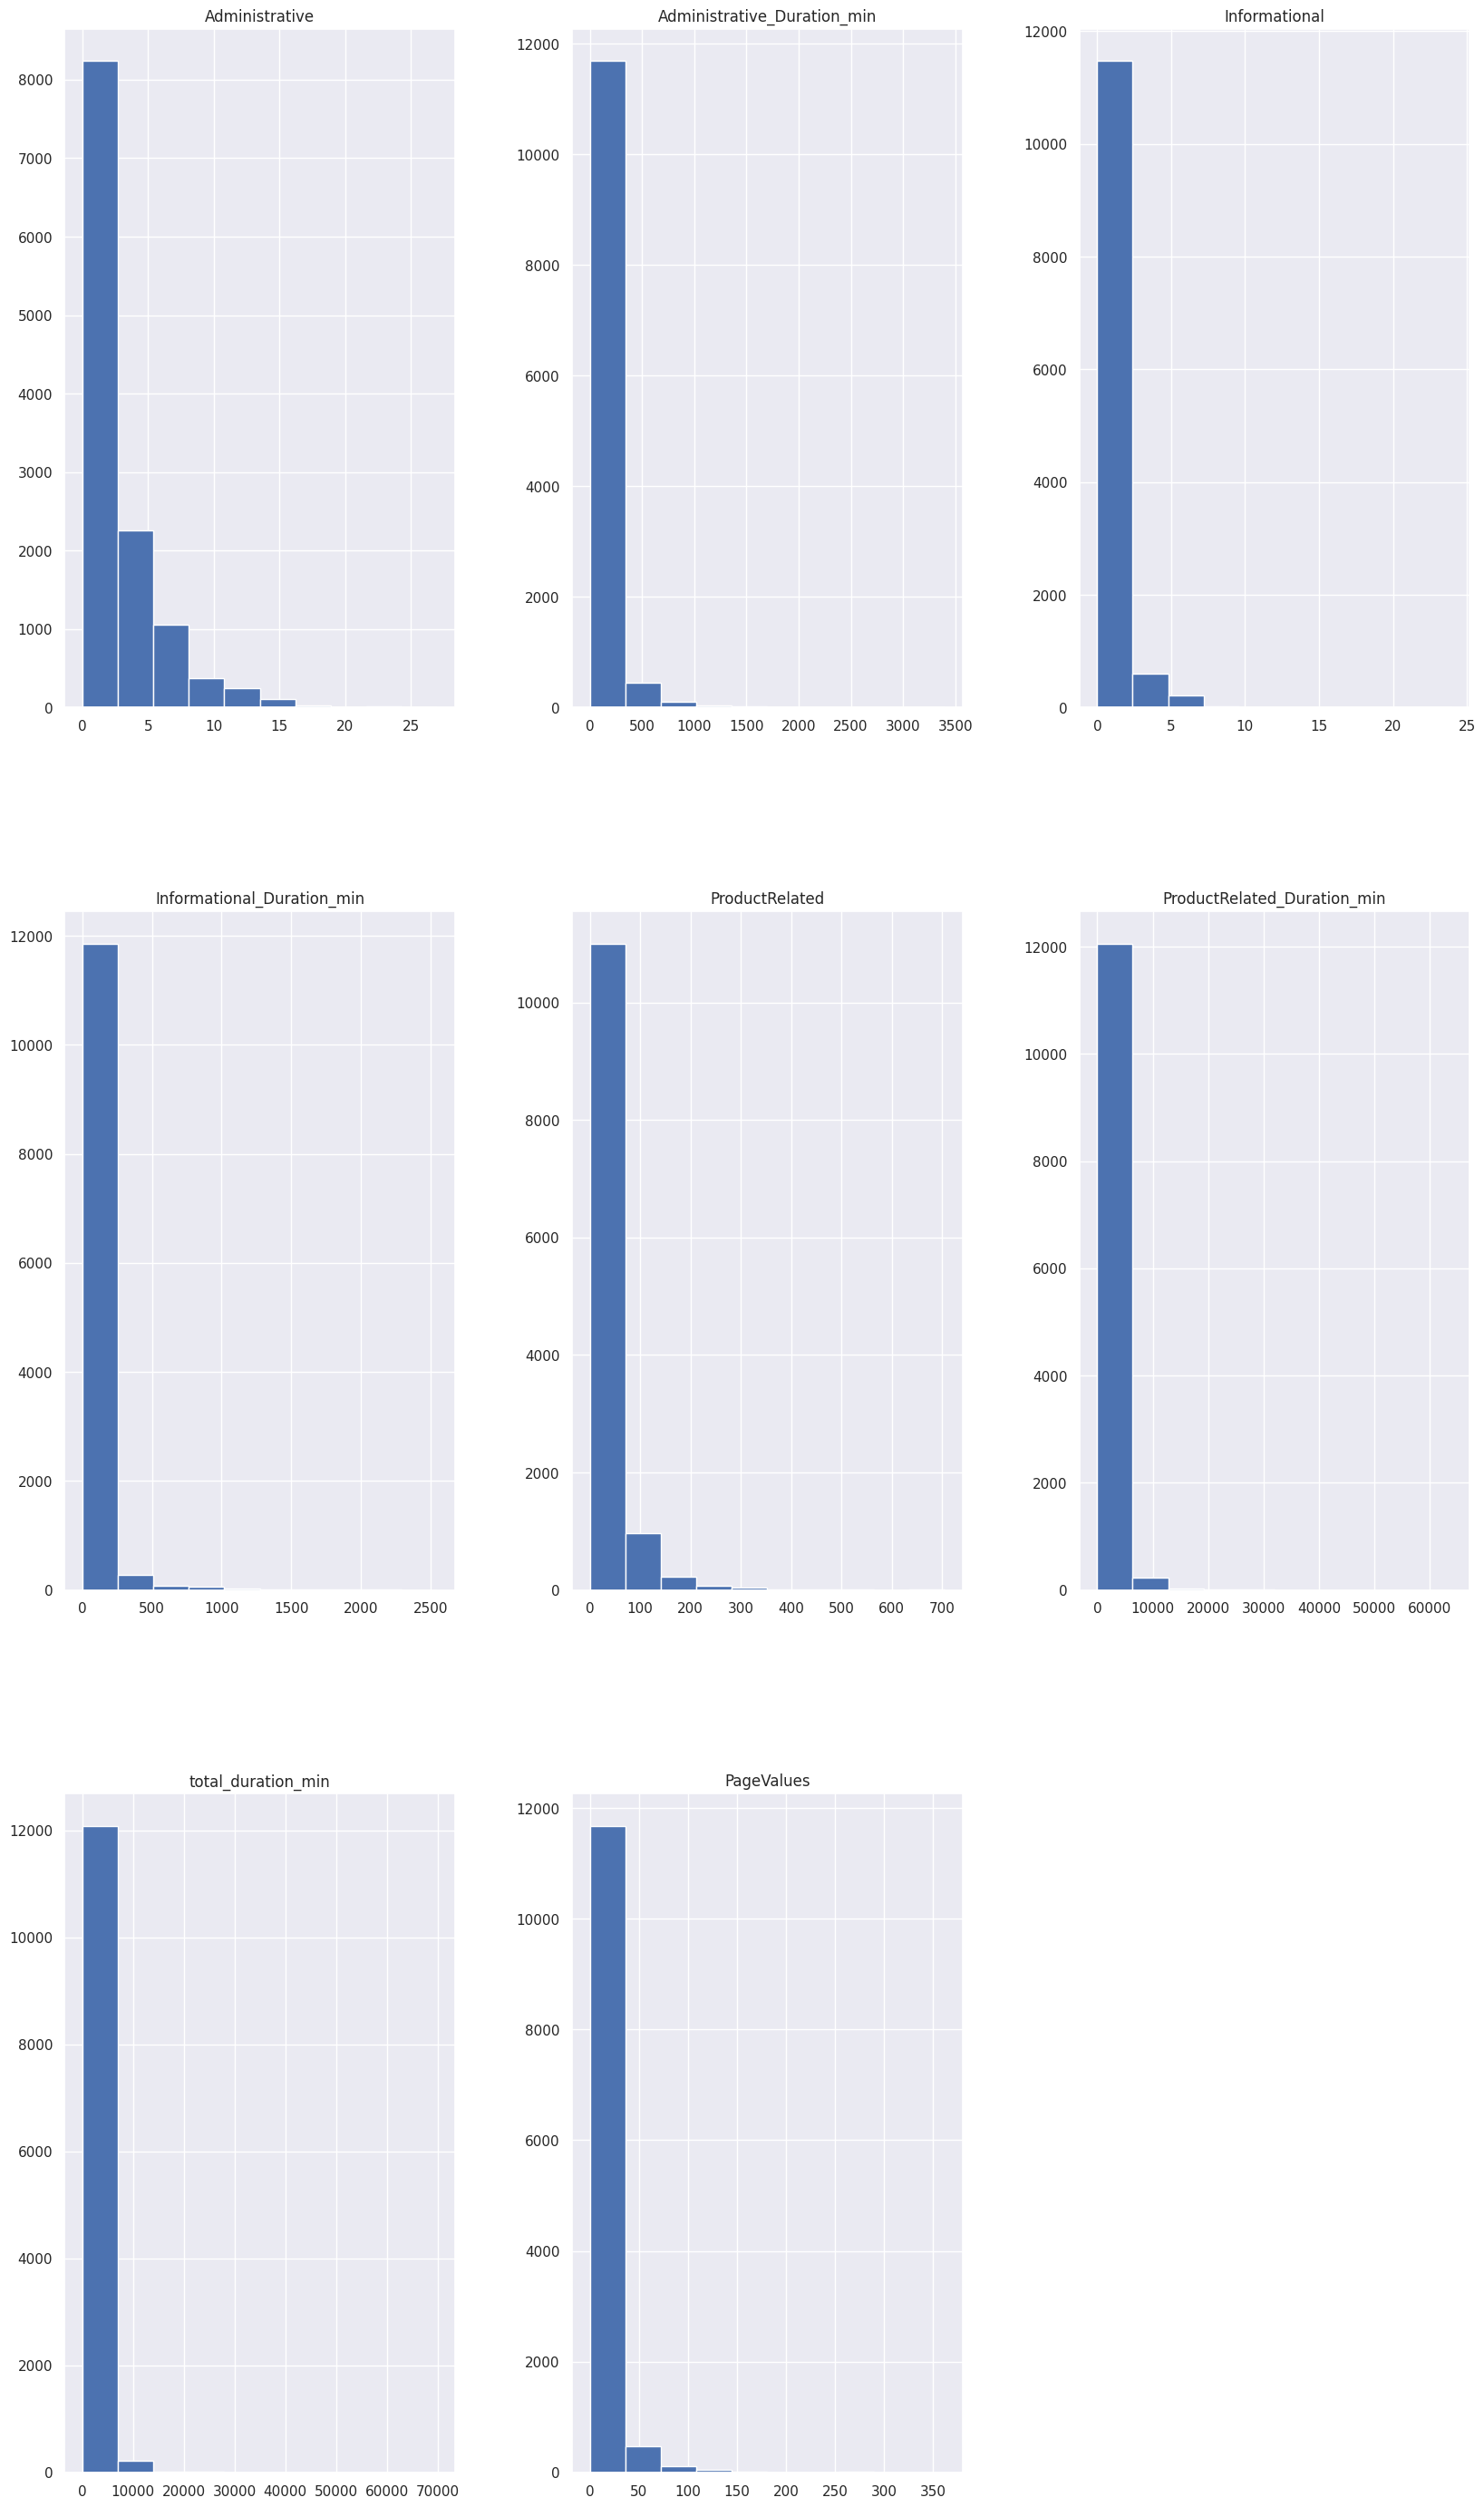

In [70]:
outliers_col_list = ['Administrative', 'Administrative_Duration_min', 'Informational', 'Informational_Duration_min',
                     'ProductRelated', 'ProductRelated_Duration_min', 'total_duration_min', 'PageValues']
train_df[outliers_col_list].hist(figsize= (20,35))
plt.show()

Removing the outliers of each feature

In [71]:
outlier_val_dict = {'Administrative':18,
                    'Administrative_Duration_min':900,
                    'Informational': 7,
                    'Informational_Duration_min': 800,
                    'ProductRelated': 250,
                    'ProductRelated_Duration_min': 10000,
                    'total_duration_min': 12000,
                    'PageValues': 100}

In [74]:
train_df = remove_outlires(train_df, None, outlier_val_dict)

In [76]:
prec_eliminated = round(1-(train_df.shape[0] / records_num_before_removing_outliers), 3) * 100
print(f'Before removing outliers we have {records_num_before_removing_outliers} records in the train data')
print(f'After removing outliers we have {train_df.shape[0]} records in the train data')
print(f'Deleted {prec_eliminated}% of the records')

Before removing outliers we have 12330 records in the train data
After removing outliers we have 11913 records in the train data
Deleted 3.4000000000000004% of the records


Let's see how it looks now-

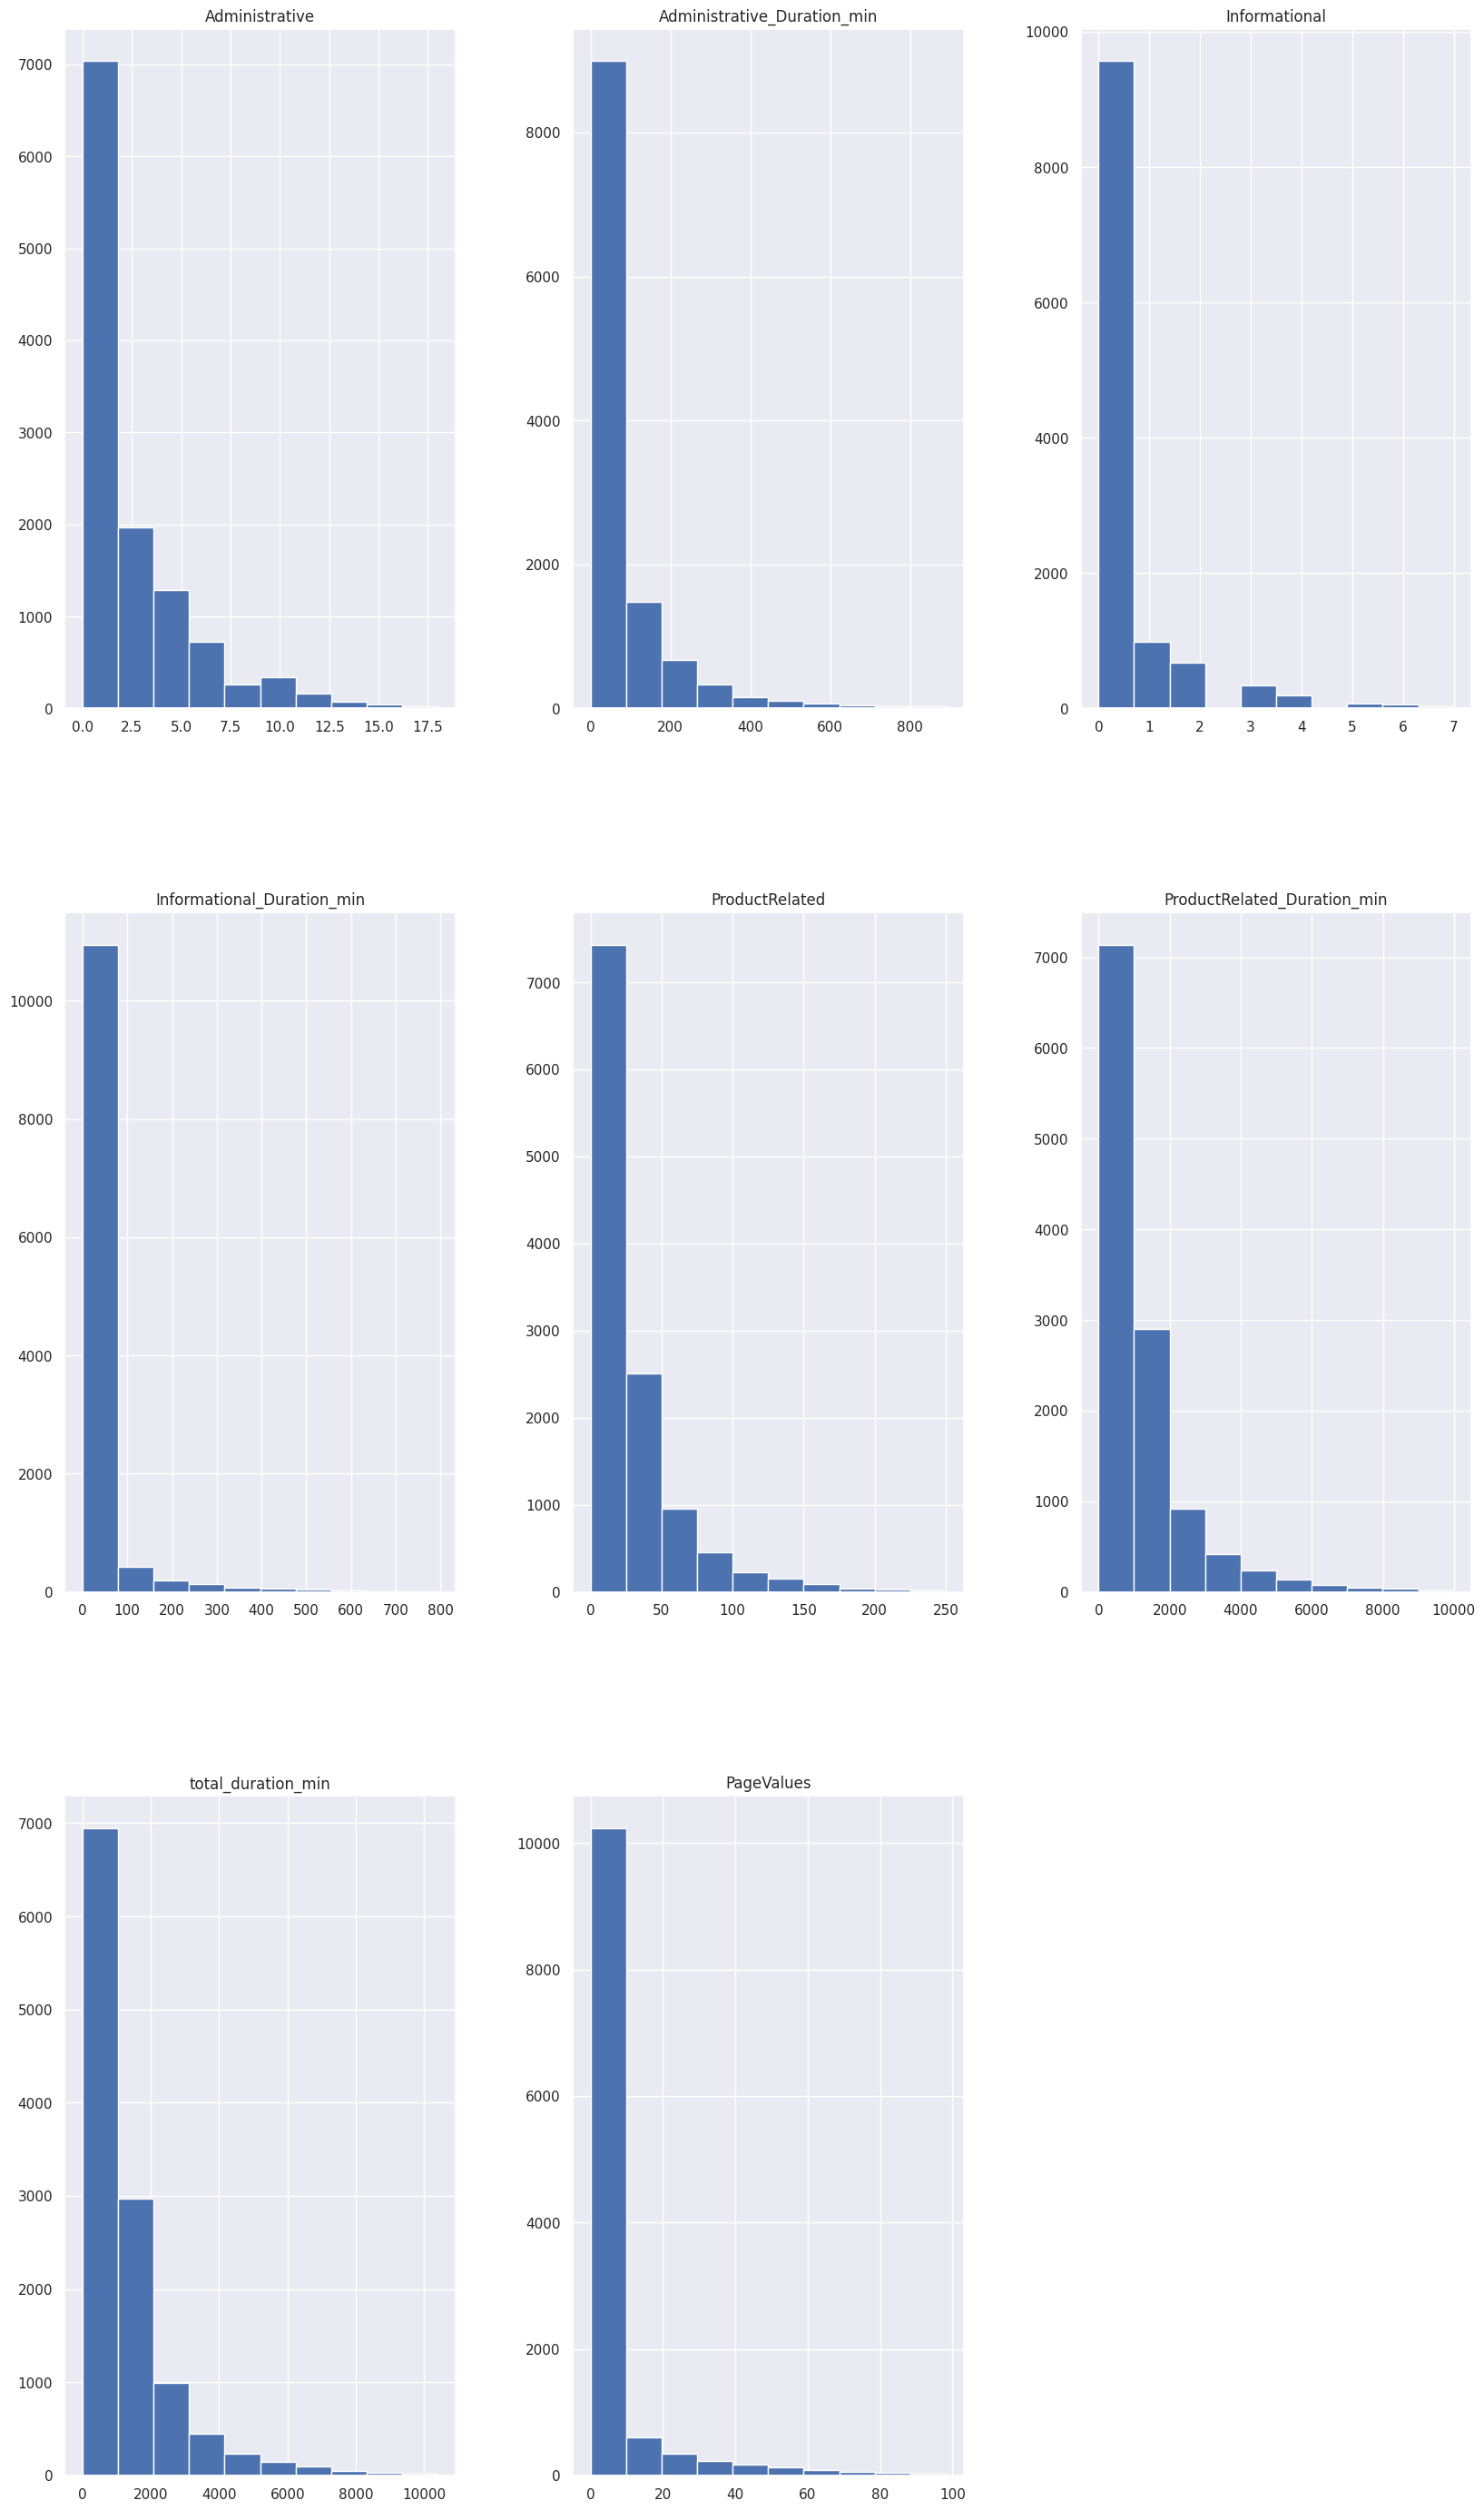

In [77]:
train_df[outliers_col_list].hist(figsize= (20,35))
plt.show()

Detecting outliers using boxplots - relevant to features that distributes normal

Let's see the boxplot from a different angle

## Data Normalization

The data we have in front of us is not entirely normalized overall, even though we can see that some columns are normalized in conjunction with others.

Normalization is the process of transforming a dataset's numerical columns into a similar scale without affecting their ranges of values.

Only in situations like ours, where features have varying ranges, is it necessary.


$$\hat X_ik = \frac{X_ik - min(X_k)}{max(X_k) - min(X_k)}$$

#### Column `A`
We thought about making it a dummy variable, but we realized that would increase the data by 96 columns.

As a result, we made the decision to keep this column and convert its values to numbers. One potential drawback is that the source of the column may be in different categories, and the numbers may be meaningless. We are unaware of this information as we do not know the identity of the column.

The fact that each category will be given a varied weight will be reflected in the disadvantage. We made this decision in light of the situation.


In [78]:
# normalize all this columns: values in each column will be between 0 to 1
mmscaler = MinMaxScaler()
columns_to_normalize = ['Administrative', 'Informational', 'Informational_Duration_min', 'Administrative_Duration_min','ProductRelated', 'ProductRelated_Duration_min', 'total_duration_min', 'BounceRates', 'ExitRates','PageValues','SpecialDay']
train_df[columns_to_normalize] = mmscaler.fit_transform(train_df[columns_to_normalize])

# normalize all this columns: values in each column will be between 0 to 1
mmscaler = MinMaxScaler()
columns_to_normalize = ['Administrative', 'Informational', 'Informational_Duration_min', 'Administrative_Duration_min',
       'ProductRelated', 'ProductRelated_Duration_min', 'total_duration_min', 'BounceRates', 'ExitRates',
        'PageValues','SpecialDay']
train_df[columns_to_normalize] = mmscaler.fit_transform(train_df[columns_to_normalize])

## Dealing With Categorical Features

Convert column from numerical to categorical

'''
The func 'get_column_letter()' changes every number to correlated letter. example: 1->A, 2->B, and so on..
The 'Region' and 'device' features are now numerical which relates to categorical variables.
We want to remove that situation, as it results in different weights for different regions and devices.
Using this categorical column, we will later create dummy variables.
'''
train_df['Region'] = train_df['Region'].apply(lambda x: 'Region_' + str(x))
train_df['Region'] = train_df['Region'].apply(lambda x: x[:-2])

train_df['device'] = train_df['device'].apply(lambda x: int(x)) #it's string of numbers, convert it to int
train_df['device'] = train_df['device'].apply(lambda x: 'device_' + get_column_letter(x))

> ### As part of the feature engineering, we convert the `Weekend` column boolean (True/False) to 0/1.

In [79]:
train_df['Weekend'] = train_df['Weekend'].apply(lambda x: 1 if x == True else 0)

Get Dummys For The Categorical Columns

In [80]:
catagorical_features = ['OperatingSystems', 'Month', 'Region', 'Browser', 'VisitorType','Weekend']
train_df = pd.get_dummies(train_df, prefix='dummy', columns = catagorical_features, drop_first= True)

In [81]:
features_after_adding_dummies = train_df.shape[1]
print(f'Now we have {features_after_adding_dummies} features')

Now we have 54 features


## Dimensionality

#### Let's examine the correlation between features

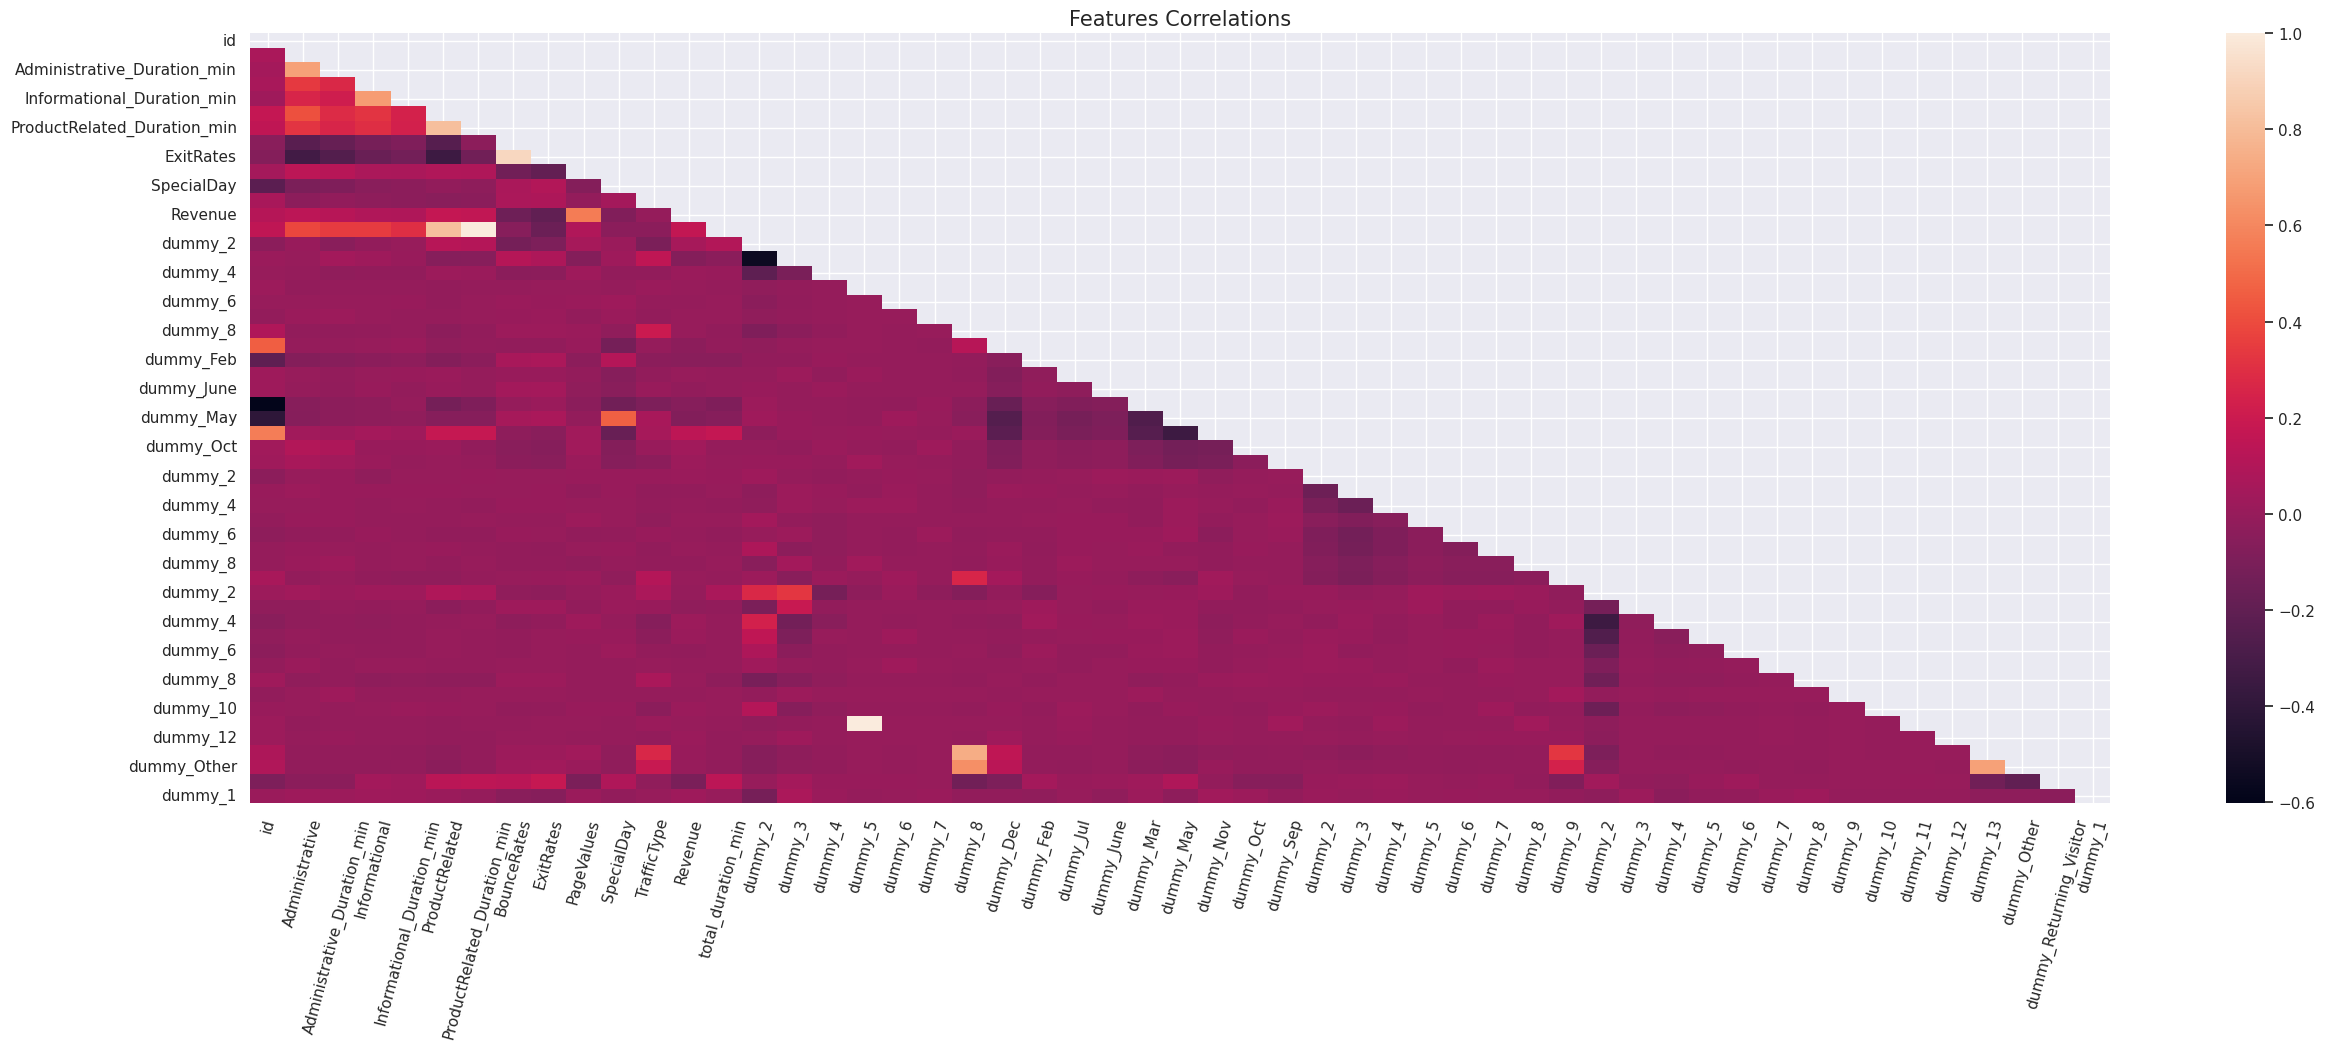

In [82]:
corr_before_dropping = train_df.corr()
plt.figure(figsize = (30,10))
mask_ut = np.triu(np.ones(corr_before_dropping.shape)).astype(np.bool)
hmap = sns.heatmap(corr_before_dropping, mask=mask_ut)
plt.xticks(rotation=75)
plt.title('Features Correlations', fontdict = {'fontsize':15})
plt.show()

In [83]:
corr_t_before_dropping = corr_before_dropping[(abs(corr_before_dropping)>=0.65) & (abs(corr_before_dropping) != 1)].unstack()
corr_t_before_dropping.sort_values(ascending = False).dropna()

ProductRelated_Duration_min  total_duration_min             0.994225
total_duration_min           ProductRelated_Duration_min    0.994225
BounceRates                  ExitRates                      0.913485
ExitRates                    BounceRates                    0.913485
ProductRelated               total_duration_min             0.817782
total_duration_min           ProductRelated                 0.817782
ProductRelated               ProductRelated_Duration_min    0.813464
ProductRelated_Duration_min  ProductRelated                 0.813464
dummy_8                      dummy_13                       0.740405
dummy_13                     dummy_8                        0.740405
                             dummy_Other                    0.696234
dummy_Other                  dummy_13                       0.696234
Administrative               Administrative_Duration_min    0.695121
Administrative_Duration_min  Administrative                 0.695121
Informational                Infor

### Using Pearsom Correlation

$$P_x,_y = \frac{Cov(X,Y)}{SD(X) * SD(Y)}$$
We found that the results are very similar to the correlations table above, so we decided to base our next steps on the table above.

In [84]:
stats.pearsonr(train_df.ProductRelated_Duration_min, train_df.total_duration_min)

PearsonRResult(statistic=0.9942247301685583, pvalue=0.0)

In [85]:
stats.pearsonr(train_df.Administrative_Duration_min, train_df.Administrative)

PearsonRResult(statistic=0.6951205221925352, pvalue=0.0)

A high correlation was found between several columns. Based on this, at first we thought it would be appropriate to lower these columns in order to reduce the dimensions, **but later on after running the models, we realized it would be better to reduce the dimensions with the help of important features.**

## Dimensionality Reduction

- High dimensionality increases the model variance
- Exposure to more noise than signal
- Curse of dimensionality - the space is sparser

In [86]:
train_df = train_df.drop('TrafficType', axis=1)

In [87]:
train_df

,id,Administrative,Administrative_Duration_min,Informational,Informational_Duration_min,ProductRelated,ProductRelated_Duration_min,BounceRates,ExitRates,PageValues,...,dummy_7,dummy_8,dummy_9,dummy_10,dummy_11,dummy_12,dummy_13,dummy_Other,dummy_Returning_Visitor,dummy_1
0,1,0.000000,0.000000,0.0,0.0,0.004,0.126880,1.000000,1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,2,0.000000,0.000000,0.0,0.0,0.008,0.006401,0.000000,0.500000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,3,0.000000,0.000000,0.0,0.0,0.004,0.126880,1.000000,1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
3,4,0.000000,0.000000,0.0,0.0,0.008,0.000267,0.250000,0.700000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,5,0.000000,0.000000,0.0,0.0,0.040,0.062764,0.100000,0.250000,0.000000,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,12326,0.166667,0.163074,0.0,0.0,0.212,0.178420,0.035714,0.145153,0.124741,...,0,0,0,0,0,0,0,0,1,1
12326,12327,0.000000,0.000000,0.0,0.0,0.020,0.046586,0.000000,0.106667,0.000000,...,0,0,0,0,0,0,0,0,1,1
12327,12328,0.000000,0.000000,0.0,0.0,0.024,0.018429,0.416667,0.433333,0.000000,...,0,0,0,0,0,0,0,0,1,1
12328,12329,0.222222,0.084349,0.0,0.0,0.060,0.034608,0.000000,0.105263,0.000000,...,0,0,0,0,0,0,0,0,1,0


In [88]:
columns_to_remove = train_df.filter(like='dummy').columns
train_df = train_df.drop(columns=columns_to_remove)


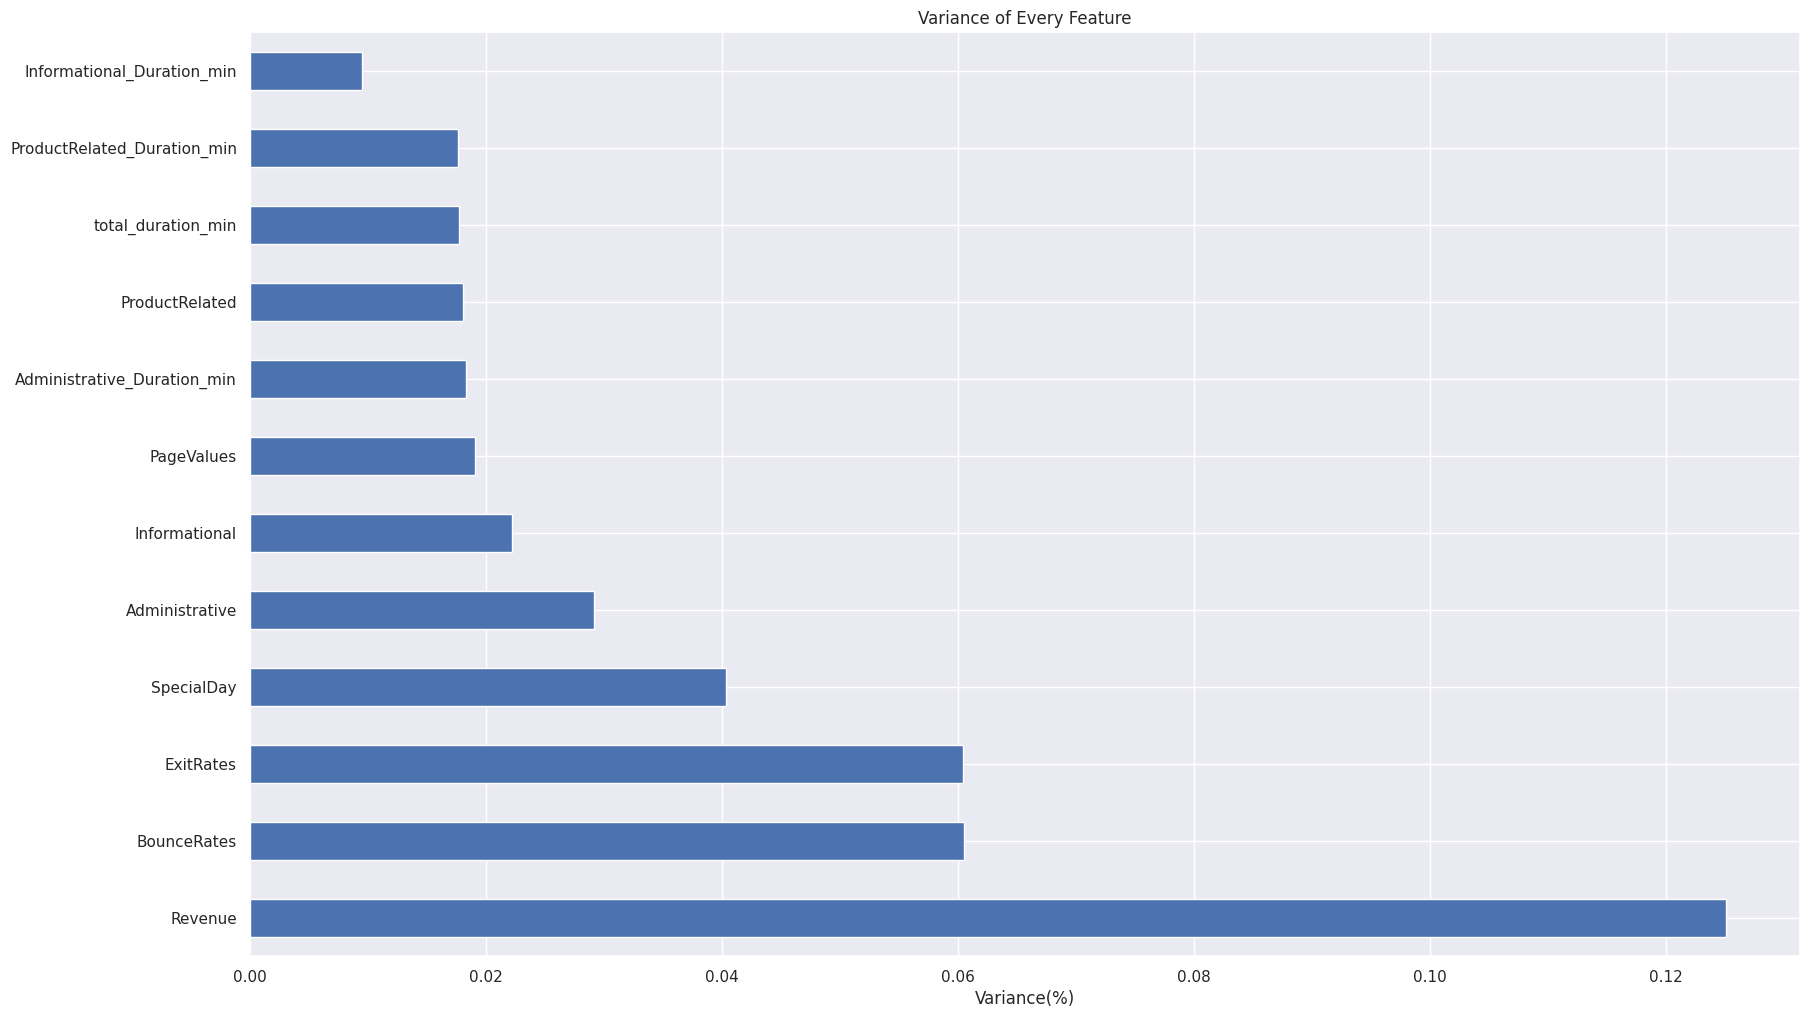

In [89]:
r= train_df.loc[:, train_df.columns != 'id'].var().sort_values(ascending = False)
r.plot.barh(figsize=(20, 12))
plt.title("Variance of Every Feature")
plt.xlabel("Variance(%)")
plt.show()

Based on this graph, we decided what number of features we would like to keep in the data.

In addition, we will later select the features that have the highest correlation for the label, we found that there is a high match between the features that have the highest variance and those we chose to leave based on the correlation.

In [90]:
# leave the only 34 features with the highest correlation to the label
diluted_features = dilute_features(train_df,11)
# diluted_features.remove('dummy_12') ## we removed that column becouse thie column not found in the validation.

Creating some variables we will use in the pipline, test processing and validation processing.

In [91]:
Y_train = train_df.Revenue
X_train = train_df
X_train.drop('Revenue', axis = 1, inplace = True)
X_train.shape , Y_train.shape

((11913, 13), (11913,))

In [92]:
X_train = X_train[diluted_features] #keep only the diluted features

In [93]:
X_train.shape

(11913, 11)

# Validation Set Processing

In this stage, we will first split the data into train and validation, and then process the validation set similarly to how we will process the test set.

We will perform each process on both train and val sets.

In [94]:
train_and_val_data = pd.read_csv('online_shoppers_intention.csv')

In [95]:
train_and_val_data.insert(0, 'id', range(1, len(train_and_val_data) + 1))
train_and_val_data['id'] = train_and_val_data['id'].astype(int)

In [96]:
train_and_val_data = train_and_val_data.assign(total_duration=train_and_val_data['ProductRelated_Duration'] + train_and_val_data['Administrative_Duration'] + train_and_val_data['Informational_Duration'])

In [97]:
train_and_val_data

,id,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,total_duration
0,1,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,0.000000
1,2,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,64.000000
2,3,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,0.000000
3,4,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2.666667
4,5,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,627.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,12326,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False,1928.791667
12326,12327,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False,465.750000
12327,12328,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False,184.250000
12328,12329,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False,421.000000


In [98]:
# replace_values(train_and_val_data, ["total_duration"], 0, np.nan)
train_and_val_data['Informational_Duration'] = train_and_val_data['Informational_Duration'].astype(str).str.replace('minutes', '')
train_and_val_data['ProductRelated_Duration'] = train_and_val_data['ProductRelated_Duration'].astype(str).str.replace('minutes', '')
train_and_val_data = train_and_val_data.astype({'ProductRelated_Duration' : float}, errors='raise')
train_and_val_data = train_and_val_data.astype({'Informational_Duration' : float}, errors='raise')
train_and_val_data.rename(columns = {'Administrative_Duration': 'Administrative_Duration_min','Informational_Duration': 'Informational_Duration_min', 'ProductRelated_Duration': 'ProductRelated_Duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
replace_values(train_and_val_data, ["Informational_Duration_min", "ProductRelated_Duration_min"], 0, np.nan)

In [99]:
find_zeros_and_replace(train_and_val_data, 'Administrative_Duration_min', 'Administrative')
find_zeros_and_replace(train_and_val_data, 'Informational_Duration_min', 'Administrative')
find_zeros_and_replace(train_and_val_data, 'ProductRelated_Duration_min', 'ProductRelated')
y_train = train_and_val_data.iloc[:,-1]
train_and_val_data = train_and_val_data.iloc[:,:-1]

In [100]:
y_train = train_and_val_data.iloc[:,-1]

In [101]:
# spliting train to - train and validation
train_data, validation_data, train_labels, validation_labels = train_test_split(train_and_val_data, y_train,
                                                        test_size = 0.2,
                                                        random_state= 42,
                                                        shuffle=True)

In [102]:
y_train

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12330, dtype: bool

In [103]:
nan_train_indices = np.isnan(train_labels)
nan_validation_indices = np.isnan(validation_labels)

# Replace NaN labels in train_labels and validation_labels with the most frequent value
most_frequent_train_label = np.nanmax(np.unique(train_labels, return_counts=True)[1])
most_frequent_validation_label = np.nanmax(np.unique(validation_labels, return_counts=True)[1])

train_labels[nan_train_indices] = most_frequent_train_label
validation_labels[nan_validation_indices] = most_frequent_validation_label

In [104]:
print('Train Dimensions:')
print(f'        data: {train_data.shape}')
print(f'        labels: {train_labels.shape}')

print('\nValidation Dimensions:')
print(f'        data: {validation_data.shape}')
print(f'        labels: {validation_labels.shape}')

Train Dimensions:
        data: (9864, 19)
        labels: (9864,)

Validation Dimensions:
        data: (2466, 19)
        labels: (2466,)


In [105]:
train_data['total_duration_min'] = train_data['Informational_Duration_min'] + train_data['ProductRelated_Duration_min'] + train_data['Administrative_Duration_min']

In [106]:
train_data

,id,Administrative,Administrative_Duration_min,Informational,Informational_Duration_min,ProductRelated,ProductRelated_Duration_min,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,total_duration_min
1785,1786,0,0.000000,0,0.0,7,95.000000,0.014286,0.061905,0.000000,0.0,Mar,2,6,1,1,Returning_Visitor,False,False,95.0
10407,10408,2,14.000000,0,NaN,81,1441.910588,0.002469,0.013933,2.769599,0.0,Nov,2,2,3,2,Returning_Visitor,False,False,NaN
286,287,0,0.000000,0,0.0,1,NaN,0.200000,0.200000,0.000000,0.0,Mar,2,2,1,1,Returning_Visitor,False,False,NaN
6520,6521,5,49.200000,4,379.0,5,74.600000,0.000000,0.018182,8.326728,0.0,Sep,2,2,8,2,New_Visitor,False,False,502.8
12251,12252,0,0.000000,1,5.0,9,279.000000,0.040000,0.041667,0.000000,0.0,Nov,3,2,7,8,New_Visitor,True,False,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,11965,14,1005.608333,0,NaN,25,732.344872,0.000000,0.015676,0.000000,0.0,Nov,3,2,1,2,Returning_Visitor,False,False,NaN
5191,5192,0,0.000000,0,0.0,14,340.000000,0.000000,0.015385,23.388000,0.0,May,2,2,3,1,Returning_Visitor,True,True,340.0
5390,5391,0,0.000000,0,0.0,3,189.000000,0.000000,0.066667,0.000000,0.0,May,2,2,3,4,Returning_Visitor,False,False,189.0
860,861,0,0.000000,0,0.0,13,305.000000,0.000000,0.016667,0.000000,0.0,Mar,1,1,1,2,New_Visitor,False,False,305.0


In [107]:
# train_data process
train_data, train_labels = remove_records_with_many_nans_VAL(train_data, train_labels, 5)
columns_list = ['Administrative', 'Administrative_Duration_min', 'ProductRelated', 'ProductRelated_Duration_min']
for col in columns_list:
    train_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(train_data, ['Informational_Duration_min'], np.nan, 0)
train_data['SpecialDay'].fillna(value = train_data.SpecialDay.mean(axis = 0, skipna = True), inplace=True)
most_frequent_val_col_device = train_data.OperatingSystems.value_counts().index[0]
train_data = train_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_data['Weekend'] = train_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
train_data, train_labels = remove_outlires(train_data, train_labels, outlier_val_dict)
train_data[columns_to_normalize] = mmscaler.fit_transform(train_data[columns_to_normalize])
train_data['Region'] = train_data['Region'].apply(lambda x: 'Region_' + str(x))
train_data['Region'] = train_data['Region'].apply(lambda x: x[:-2])
train_data['OperatingSystems'] = train_data['OperatingSystems'].apply(lambda x: int(x)) #it's string of numbers, convert it to int
train_data['OperatingSystems'] = train_data['OperatingSystems'].apply(lambda x: 'device_' + get_column_letter(x))
train_data['Weekend'] = train_data['Weekend'].apply(lambda x: 1 if x == True else 0)

In [108]:
validation_data['total_duration_min'] = validation_data['Informational_Duration_min'] + validation_data['ProductRelated_Duration_min'] + validation_data['Administrative_Duration_min']

In [109]:
# validation_data process
# Fill the columns in 'columns_list' with the mean of the same columns in train_data
for col in columns_list:
    validation_data[col].fillna(value = train_data[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(validation_data, ['Informational_Duration_min'], np.nan, 0)
validation_data['SpecialDay'].fillna(value = train_data.SpecialDay.mean(axis = 0, skipna = True), inplace=True)
validation_data['OperatingSystems'] = validation_data['OperatingSystems'].replace(np.nan, most_frequent_val_col_device)
fill_nan_with_most_frequent_value(train_data, validation_data)
validation_data['Weekend'] = validation_data['Month'].apply(lambda x: season_dict[x]) # insert the new column
validation_data[columns_to_normalize] = mmscaler.fit_transform(validation_data[columns_to_normalize])
validation_data['OperatingSystems'] = validation_data['OperatingSystems'].apply(lambda x: int(x) if x != np.nan else x) #it's string of numbers, convert it to int
validation_data['OperatingSystems'] = validation_data['OperatingSystems'].apply(lambda x: 'device_' + get_column_letter(x))
train_data['Region'] = train_data['Region'].apply(lambda x: 'Region_' + str(x))
train_data['Region'] = train_data['Region'].apply(lambda x: x[:-2])
validation_data['Weekend'] = validation_data['Weekend'].apply(lambda x: 1 if x == True else 0)

In [110]:
# Now let's get dummies
train_data = pd.get_dummies(train_data, prefix='dummy', columns = catagorical_features, drop_first= True)
validation_data = pd.get_dummies(validation_data, prefix='dummy', columns = catagorical_features, drop_first= True)

In [111]:
# keep the only the diluted features
train_data = train_data[diluted_features]
validation_data = validation_data[diluted_features]

# Test Processing

As we have noted, the records we removed from the training set (using two functions - one lowers values of rows with many missing values and the other lowers values of rows with extreme values) - we did not perform on a validation set and also on the test set.

In [112]:
# load the test data
test_df = pd.read_csv('Emp_dataset.csv')

In [113]:
test_df.insert(0, 'id', range(1, len(test_df) + 1))
test_df['id'] = test_df['id'].astype(int)

In [114]:
test_df = test_df.assign(total_duration=test_df['ProductRelated_Duration'] + test_df['Administrative_Duration'] + test_df['Informational_Duration'])

Cleaning the data - same as we did for the train data

In [115]:
test_df["total_duration"] = test_df["total_duration"].replace({0:np.nan})
test_df['Informational_Duration'] = test_df['Informational_Duration'].astype(str).str.replace('minutes', '')
test_df['ProductRelated_Duration'] = test_df['ProductRelated_Duration'].astype(str).str.replace('minutes', '')
test_df = test_df.astype({'ProductRelated_Duration' : float}, errors='raise')
test_df = test_df.astype({'Informational_Duration' : float}, errors='raise')
# add the unit of time to the columns names
test_df.rename(columns = {'Administrative_Duration': 'Administrative_Duration_min','Informational_Duration': 'Informational_Duration_min', 'ProductRelated_Duration': 'ProductRelated_Duration_min',\
                                                    'total_duration': 'total_duration_min'}, inplace = True)
# replacing 0 with nan
test_df["Informational_Duration_min"] = test_df["Informational_Duration_min"].replace({0:np.nan})
test_df["ProductRelated_Duration_min"] = test_df["ProductRelated_Duration_min"].replace({0:np.nan})

Outliers & Filling Missing Values

In [116]:
find_zeros_and_replace(test_df, 'Administrative_Duration_min', 'Administrative')
find_zeros_and_replace(test_df, 'Informational_Duration_min', 'Informational')
find_zeros_and_replace(test_df, 'ProductRelated_Duration_min', 'ProductRelated')

In order to fill in the missing values in the test data, we will use the `train_data_for_test_preprocessing` (which is a copy of the train data).
As we don't want to learn from the test data, it would be a mistake to fill the missing values based on the test data.

In [117]:
# most_frequent_val_col_A_from_train_and_val = train_and_val_data.A.value_counts().index[0]
most_frequent_val_col_device_from_train_and_val = train_and_val_data.OperatingSystems.value_counts().index[0]

In [118]:
test_df.isna().sum()

id                                 0
Administrative                 11222
Administrative_Duration_min    11222
Informational                  11222
Informational_Duration_min     11222
ProductRelated                 11222
ProductRelated_Duration_min    11223
BounceRates                    11222
ExitRates                      11222
PageValues                     11222
SpecialDay                     11222
Month                          11222
OperatingSystems               11222
Browser                        11222
Region                         11222
TrafficType                    11222
VisitorType                    11222
Weekend                        11222
Revenue                        11222
total_duration_min             11223
dtype: int64

In [119]:
test_df = test_df.assign(total_duration_min=test_df['ProductRelated_Duration_min'] + test_df['Administrative_Duration_min'] + test_df['Informational_Duration_min'])

In [120]:
train_and_val_data = train_and_val_data.assign(total_duration_min=train_and_val_data['ProductRelated_Duration_min'] + train_and_val_data['Administrative_Duration_min'] + train_and_val_data['Informational_Duration_min'])

In [121]:
columns_list = ['Administrative', 'Administrative_Duration_min', 'ProductRelated', 'ProductRelated_Duration_min']
for col in columns_list:
    test_df[col].fillna(value = train_df[col].mean(axis = 0, skipna = True), inplace = True)
replace_values(test_df, ['Informational_Duration_min'], np.nan, 0)
test_df['SpecialDay'].fillna(value = train_df.SpecialDay.mean(axis = 0, skipna = True), inplace=True)
test_df['OperatingSystems'] = test_df['OperatingSystems'].replace(np.nan, most_frequent_val_col_device_from_train_and_val)
fill_nan_with_most_frequent_value(train_and_val_data, test_df)
test_df[columns_to_normalize] = mmscaler.fit_transform(test_df[columns_to_normalize])
test_df['OperatingSystems'] = test_df['OperatingSystems'].apply(lambda x: int(x) if x != np.nan else x)
test_df['OperatingSystems'] = test_df['OperatingSystems'].apply(lambda x: 'device_' + get_column_letter(x))
test_df['Weekend'] = test_df['Weekend'].apply(lambda x: 1 if x == True else 0)
test_df = pd.get_dummies(test_df, prefix='dummy', columns = catagorical_features, drop_first= True)
test_df = test_df[diluted_features]

In [122]:
print(f'Now we do not have missing values in the test data.. right? Answer-> {(test_df.isna().sum() == 0).all()}')

Now we do not have missing values in the test data.. right? Answer-> True


In [123]:
sorted(list(test_df.columns)) == sorted(list(X_train.columns))

True

#### Dimensionality Reduction

In contrast to the processing of the data on the training, here at the stage of lowering the dimensions and feature selection of course we did not make a selection of the features according to the correlation to the label, we chose the same features that we chose in the training data set.

# Models

First, let's split the train data into train and validation ***************

In [124]:
print('Train Dimensions:')
print(f'        data: {train_data.shape}')
print(f'        labels: {train_labels.shape}')

print('\nValidation Dimensions:')
print(f'        data: {validation_data.shape}')
print(f'        labels: {validation_labels.shape}')

Train Dimensions:
        data: (9531, 11)
        labels: (9531,)

Validation Dimensions:
        data: (2466, 11)
        labels: (2466,)


In [125]:
train_labels_copy = train_labels
validation_labels_copy = validation_labels
train_labels_copy

1785     False
10407    False
286      False
6520     False
12251    False
         ...  
11284     True
5191      True
5390     False
860      False
7270     False
Name: Revenue, Length: 9531, dtype: bool

### 1. KNN

In [126]:
validation_labels

8916     False
772       True
12250    False
7793     False
6601     False
         ...  
295       True
3694     False
4974     False
10383     True
2611     False
Name: Revenue, Length: 2466, dtype: bool

In [127]:
# Set your threshold

# Create binary labels based on the threshold
train_labels = (train_labels_copy == True).astype(int)
validation_labels = (validation_labels_copy == True).astype(int)

In [128]:
y_train

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12330, dtype: bool

Model : KNeighborsClassifier()
Best Params: {'n_neighbors': 300} 

Train AUC: 0.5896100843124243
K-fold Cross Validation TRAIN Accuracy Mean: 83.61 %
Train accuracy: 85.62 %
Train Standard Deviation: 0.50 %
Train Mse: 14.38 %

Validation AUC: 0.594814735882454
K-fold Cross Validation VALIDATION Accuracy Mean: 80.90 %
Val accuracy: 83.33 %
Val Standard Deviation: 2.05 %
Val Mse: 16.67 %



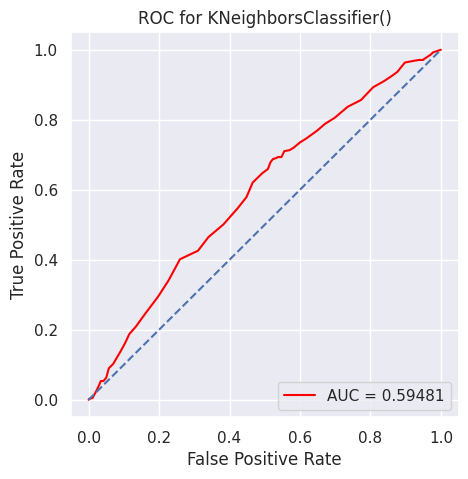

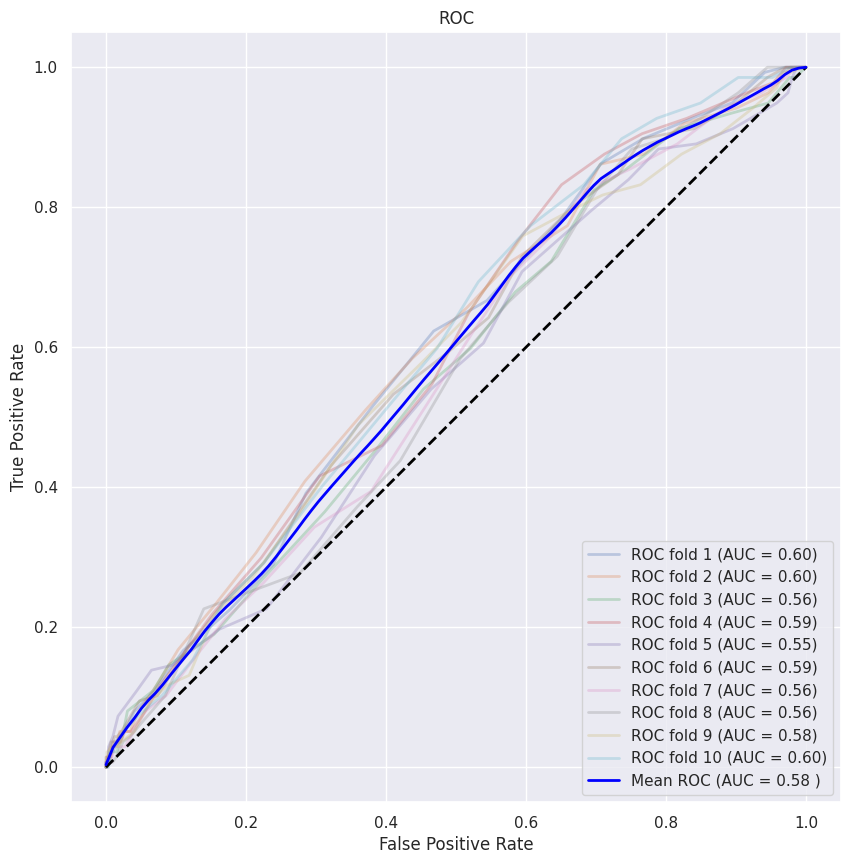

In [129]:
# Assuming train_data is your DataFrame
columns_to_remove = train_data.filter(like='dummy').columns
train_data = train_data.drop(columns=columns_to_remove)
KNN_parameters = {'n_neighbors' : [295, 300, 305]}

run_model(KNeighborsClassifier(), KNN_parameters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(KNeighborsClassifier(n_neighbors = 83), train_data, train_labels, 10)

### 2. Logistic Regression

Model : LogisticRegression()
Best Params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'} 

Train AUC: 0.9037721401433831
K-fold Cross Validation TRAIN Accuracy Mean: 85.62 %
Train accuracy: 87.66 %
Train Standard Deviation: 0.03 %
Train Mse: 12.34 %

Validation AUC: 0.8648326732614654
K-fold Cross Validation VALIDATION Accuracy Mean: 83.41 %
Val accuracy: 83.58 %
Val Standard Deviation: 0.27 %
Val Mse: 16.42 %



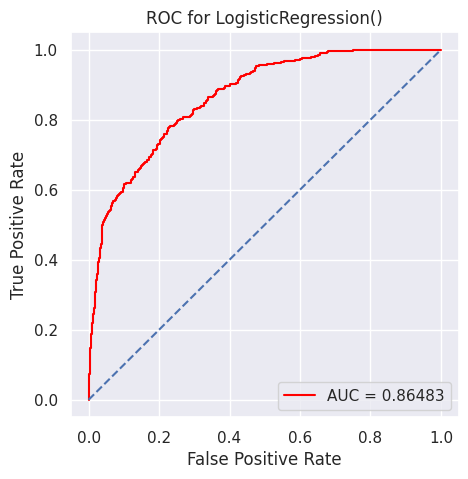

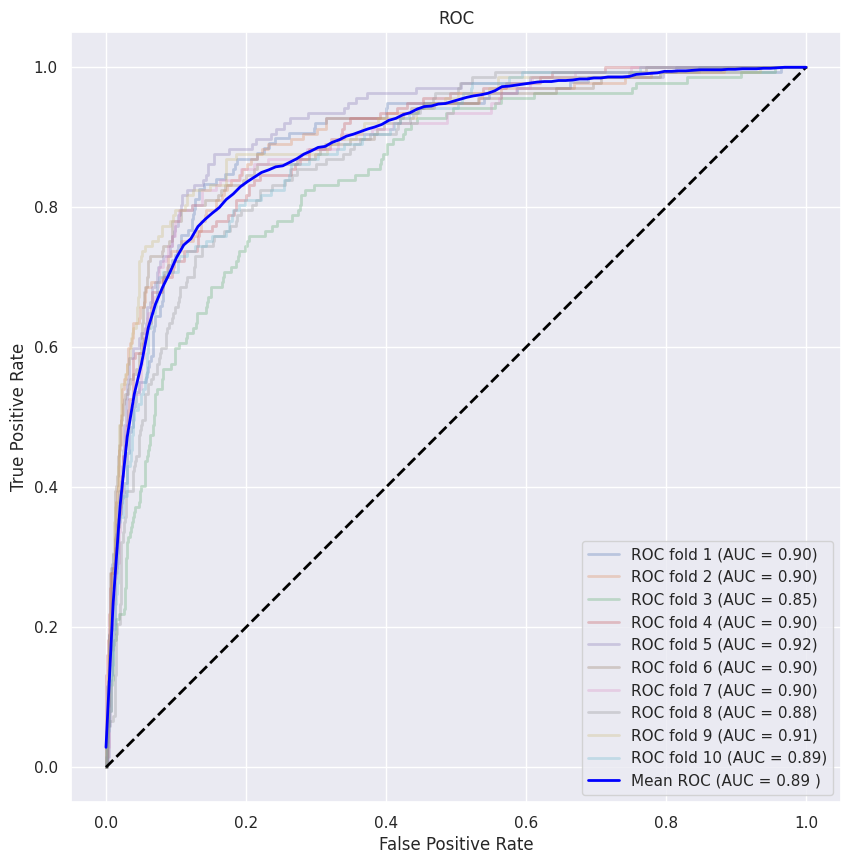

In [130]:
LogisticRegression_parameters = {'penalty' : ['l1', 'l2'], 'solver':['liblinear'], 'C' : [10**p for p in range(-10,0)]}
run_model(LogisticRegression(), LogisticRegression_parameters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear'), train_data, train_labels, 10)

### 3. Decision Tree

Model : DecisionTreeClassifier()
Best Params: {'criterion': 'entropy', 'max_depth': 5, 'random_state': 0} 

Train AUC: 0.9166815099795723
K-fold Cross Validation TRAIN Accuracy Mean: 86.33 %
Train accuracy: 91.12 %
Train Standard Deviation: 1.07 %
Train Mse: 8.88 %

Validation AUC: 0.9005967286483031
K-fold Cross Validation VALIDATION Accuracy Mean: 85.24 %
Val accuracy: 88.08 %
Val Standard Deviation: 1.88 %
Val Mse: 11.92 %



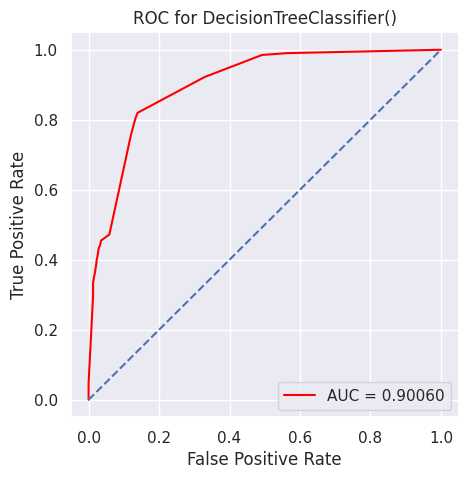

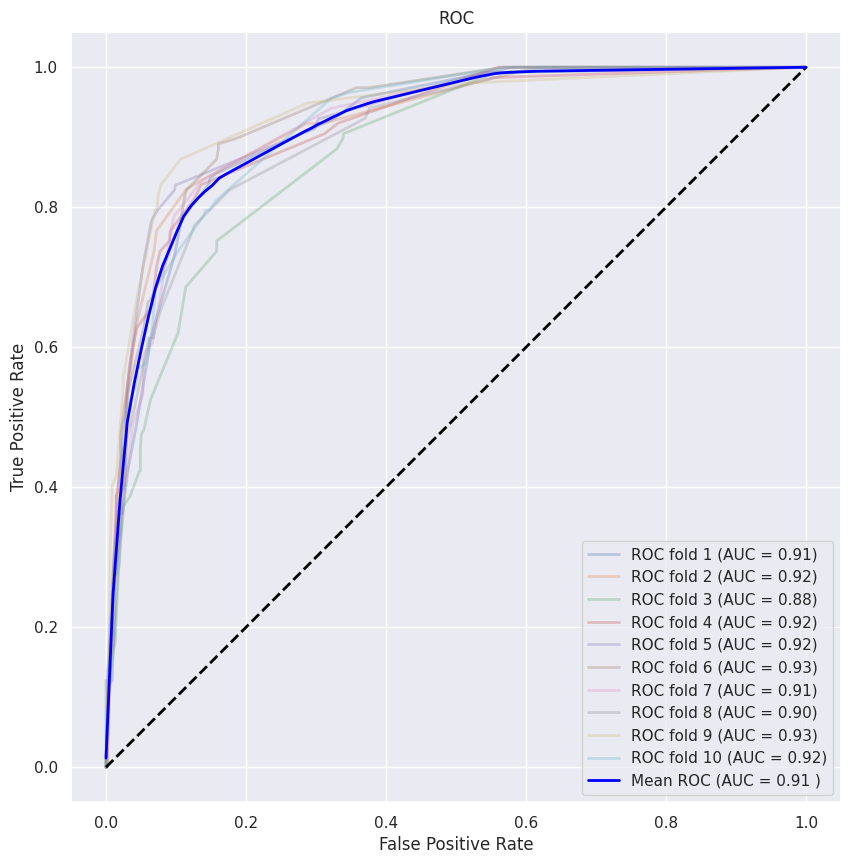

In [131]:
res = tree.DecisionTreeClassifier()
DecisionTreeClassifier_paramters = {'criterion' : ['entropy','gini'],'max_depth':range(3, 7, 2), 'random_state': [0]}

run_model(tree.DecisionTreeClassifier(), DecisionTreeClassifier_paramters, train_data, validation_data, train_labels, validation_labels)
plot_KFold(tree.DecisionTreeClassifier(criterion = 'gini',max_depth = 5, random_state = 0), train_data, train_labels, 10)

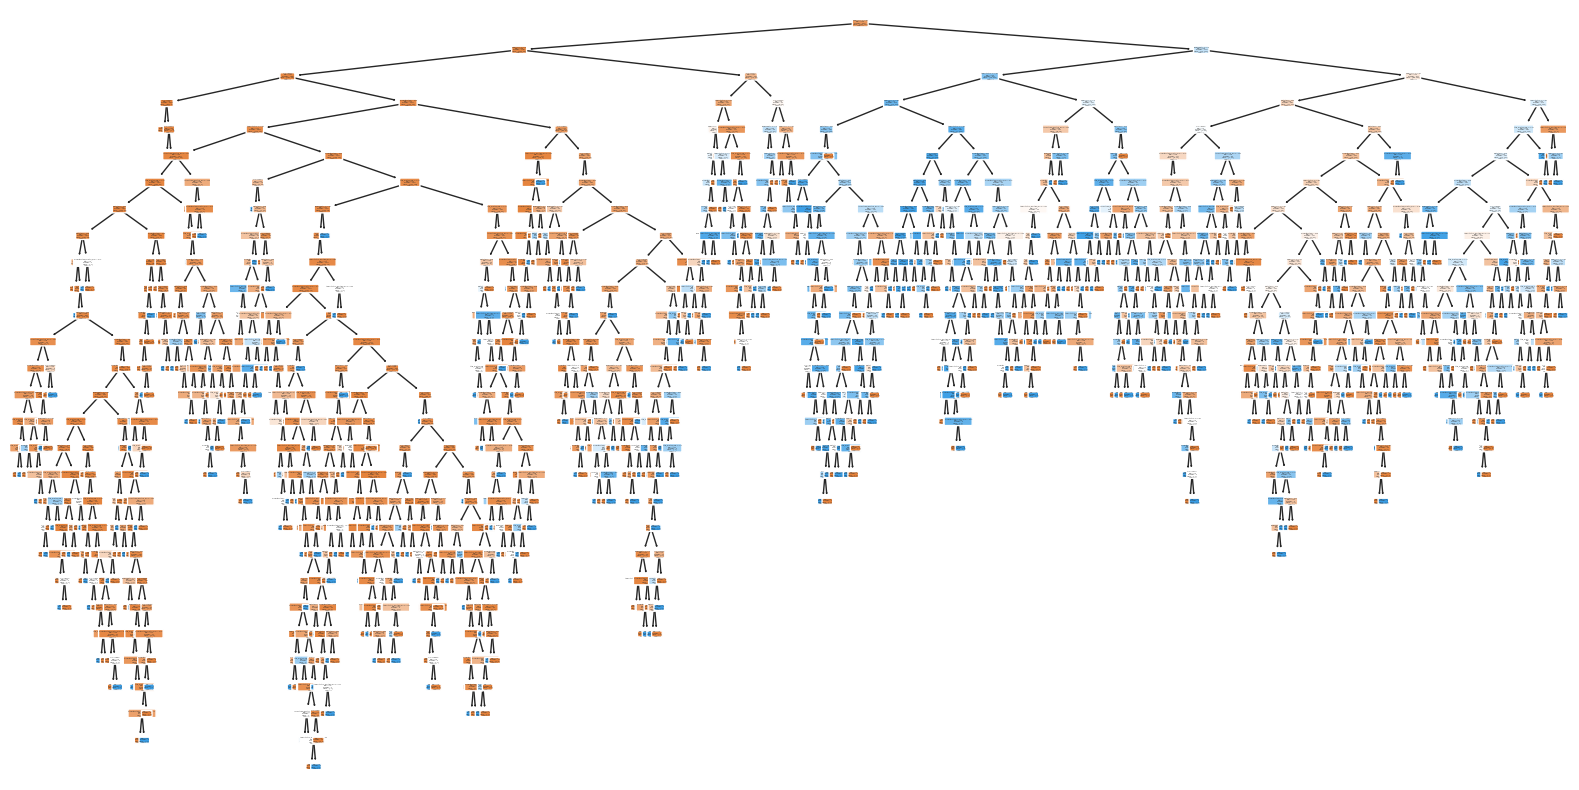

In [132]:
# here we are creating a decision tree for train data
res.fit(train_data, train_labels)
plt.figure(figsize=(20,10))
dot_data  = plot_tree(res,
                    feature_names = train_data.columns,
                    class_names = ["0","1"],
                    rounded = True, proportion = False, impurity = True,
                    label='all', precision = 2, filled = True)